# Forecast evaluation code

## Imports

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import tqdm

## Non-linear models

These three models transform the vector of explanatory variables $S_t$ into a vector of nonlinear transformed variables $G(S_t;\varphi)$.

In [2]:
def TR_model(S_t, gamma):
    return (S_t >= gamma).astype(float).reshape(-1, 1)

def LSTR_model(S_t,gamma,tau):
    return ((1+np.exp(-tau * (S_t-gamma)))**-1).reshape(-1, 1)

def ESTR_model(S_t,gamma,tau):
    return (1-np.exp(-tau * (S_t-gamma)**2)).reshape(-1, 1)

This function detects which model type it should use given the String "$\textit{model_type}$"

In [3]:
def nonlin_model(model_type, S_t, gamma, tau):
    
    if (model_type == "TR"):
        return TR_model(S_t,gamma)
        
    elif (model_type == "LSTR"):
        return LSTR_model(S_t,gamma,tau)
        
    elif (model_type == "ESTR"):
        return ESTR_model(S_t,gamma,tau)
        
    # If we pass another model that is not included, we give an error
    else:
        raise Exception("Model type unknown")

## Plot functions of nonlinear models

In [4]:
#set global variables for the plots
partitions = 1000
start = -4
finish = 3

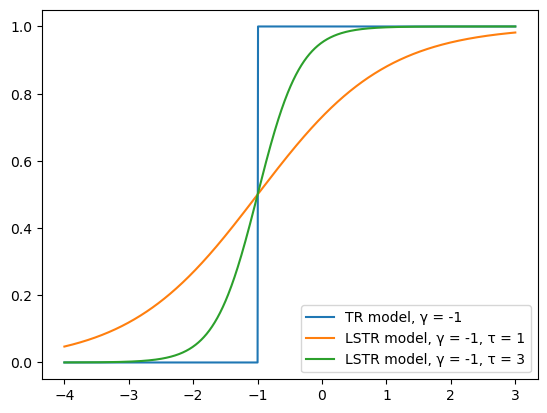

In [5]:
#define parameters
gamma_array = np.array([-1])

#plot all nonlinear functions for each parameter
for gamma in gamma_array:
    sns.lineplot(x=np.linspace(start,finish,partitions),
                 y=TR_model(np.linspace(start,finish,partitions),gamma).T[0],
                 label="TR model, \u03B3 = "+str(gamma))

#define parameters
gamma_array = np.array([-1])
tau_array = np.array([1,3])

#plot all nonlinear functions for each parameter
for gamma in gamma_array:
    for tau in tau_array:
        sns.lineplot(x=np.linspace(start,finish,partitions),
                     y=LSTR_model(np.linspace(start,finish,partitions),gamma,tau).T[0],
                     label="LSTR model, \u03B3 = "+str(gamma)+", \u03C4 = "+str(tau))

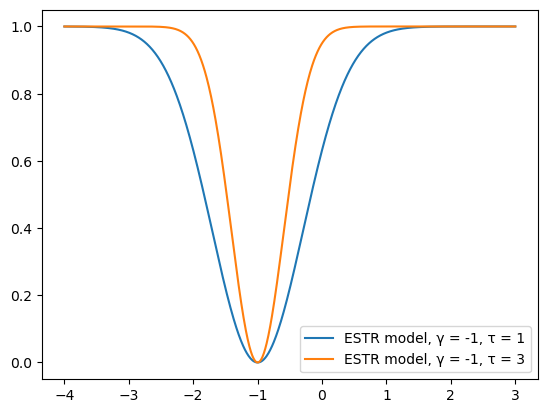

In [6]:
#define parameters
gamma_array = np.array([-1])
tau_array = np.array([1,3])

#plot all nonlinear functions for each parameter
for gamma in gamma_array:
    for tau in tau_array:
        sns.lineplot(x=np.linspace(start,finish,partitions),
                     y=ESTR_model(np.linspace(start,finish,partitions),gamma,tau).T[0],
                     label="ESTR model, \u03B3 = "+str(gamma)+", \u03C4 = "+str(tau))

## Test statistics

In [7]:
def cal_g_theta(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                h_size, # Integer
                model_type # String of model type
                ):
    
    # Determine the size of B
    B_size = round(4*(P_size/100)**(2/9)+1)
    
    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)
    
    # Check which model we should use;
    if (model_type == "TR"):
        
        # Initialize the array for the W_P's
        W_P = np.zeros(grid_elements)
        
        # Create an array of gamma value that are used in the for loop
        gamma_quantile = np.linspace(0.15,0.85,grid_elements)
    
        # Loop over every parameter value to get the W_P's and the updated critical values 
        for i in range(grid_elements):
            W_P[i], W_P_j = cal_test_statistic(S_t, L_t, R_size, P_size, h_size, B_size, v_t, model_type, np.quantile(S_t,gamma_quantile[i]))
            crit_values = np.maximum(crit_values, W_P_j)
    
    else:
        
        # Initialize the array for the W_P's
        W_P = np.zeros(grid_elements**2)
        
        # Create an array of gamma and tau values that are used in the for loop
        gamma_quantile = np.linspace(0.15,0.85,grid_elements)
        tau = np.linspace(0.1,5,grid_elements)
       
        # Loop over every parameter value to get the W_P's and the updated critical values
        for i in range(grid_elements):
            for j in range(grid_elements):
                W_P[i*grid_elements+j], W_P_j = cal_test_statistic(S_t, L_t, R_size, P_size, h_size, B_size, v_t, model_type, np.quantile(S_t,gamma_quantile[i]),tau[j])
                crit_values = np.maximum(crit_values, W_P_j)
    
    # Get the test statistic of all W_P values
    g_theta = max(W_P)
    
    # Sort the Monte Carlo simulations and get critical value
    crit_values.sort()
    final_crit_value = crit_values[round(0.95 * iterations_CV)-1]
    
    # Check if the test statistic 
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

In [16]:
def cal_test_statistic(S_t, #vector of S_t
                       L_t, #vector of loss function
                       R_size, #integer
                       P_size, #integer
                       h_size, #integer
                       B_size, #integer
                       v_t, #matrix of standard normal distribution
                       model_type, #String of model type
                       gamma, #gamma parameter
                       tau=0  #tau parameter
                       ):
    
    # Initialize the matrix of lambda_sum, V_sum, M_sum
    lambda_sum = np.zeros((2,iterations_CV))
    V_sum = np.zeros((2,2))
    M_sum = np.zeros((2,2))
    
    # Make a vector of ones for X_t
    X_t = np.ones((len(S_t),1))
    
    # Get psi (scalar)
    Q_t = np.column_stack((X_t,np.multiply(X_t,nonlin_model(model_type,S_t,gamma,tau))))
    psi = np.column_stack(estimateBeta(Q_t[R_size:R_size+P_size+h_size],L_t))

    # Loop over t
    for t in range(R_size,R_size+P_size):

        # Select X, S, Y from a certain time range
        X_sel = X_t[t-R_size:t]
        S_sel = S_t[t-R_size:t]
        L_sel = np.column_stack(L_t[t-R_size])        
        
        # Get Q_sel
        Q_sel = np.column_stack((X_sel,np.multiply(X_sel,nonlin_model(model_type,S_sel,gamma,tau))))
        
        # Get residuals
        residual_sel = L_sel - np.column_stack(Q_sel[-1]) @ np.transpose(psi)
        
        # Get score
        score = np.transpose(np.column_stack(Q_sel[-1])) * residual_sel
        
        # Get V and M sum
        V_sum += score * np.transpose(score)
        M_sum += Q_sel[-1] * np.transpose(np.column_stack(Q_sel[-1]))
        
        # Loop over all B
        for b in range(0,B_size):
            lambda_sum += score * v_t[t+b-R_size,:]
    
    # Set Hr to I2
    Hr = np.identity(2)

    # Get V_P and M_P
    V_P = V_sum / P_size
    M_P = M_sum / P_size
    
    # Get Vstar
    V_star = np.linalg.inv(M_P) @ V_P @ np.linalg.inv(M_P)
    
    # Get Wp
    W_P = P_size * (psi @ Hr @ np.linalg.inv(np.transpose(Hr) @ V_star @ Hr) @ np.transpose(Hr) @ np.transpose(psi))

    # Get W_P_j
    lambda_P = (lambda_sum / (P_size*(1+B_size))**0.5).T
    W_P_j = np.sum(np.matmul(lambda_P, np.linalg.inv(M_P) @ Hr @ np.linalg.inv(np.transpose(Hr) @ V_star @ Hr) @ np.transpose(Hr) @ np.linalg.inv(M_P)) * lambda_P,axis=1)

    print(W_P,W_P_j)
    # Return the test statistic and critical values
    return W_P, W_P_j

In [9]:
# Simple method to estimate the OLS estimates
def estimateBeta(Z_t,Y_t):
    return np.linalg.inv(np.transpose(Z_t) @ Z_t) @ np.transpose(Z_t) @ Y_t

## Model 1

In [21]:
def MonteCarlo_1(iterations,R,P,h,T,model_type = "TR"):
        
    #define variable to keep track of amount of rejects
    MC_array = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration)(iterations,R,P,h,T,model_type) for i in range(iterations))
    
    print(np.mean(MC_array))

def MonteCarlo_1(iterations,R,P,h,T,model_type = "TR"):
        
    #define variable to keep track of amount of rejects
    MC_array = [MonteCarlo_iteration(iterations,R,P,h,T,model_type) for i in range(iterations)]
    
    print(np.mean(MC_array))
    
def MonteCarlo_iteration(iterations,R,P,h,T,model_type):
    #simulate model, it only returns vectors:
    sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T)

    delta_L = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R, P, h, T)
        
    return cal_g_theta(S_t=sim_S_t, L_t=delta_L, R_size=R, P_size=P, h_size=h, model_type=model_type)


def sim_model_1(T):
    y_t = np.zeros((T,1))
    delta1 = delta2 = v = 1
    z1 = np.random.normal(0,1,(T,1))
    z2 = np.random.normal(0,1,(T,1))
    S_t = np.random.normal(0,1,(T,1))
    
    y_t = v + delta1 + z1 + delta2 + z2 + np.random.normal(0, 1, (T,1))

    #return vector values
    return z1, z2, y_t, S_t


def cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R, P, h, T):
    sim_z1 = np.column_stack([np.ones((T,1)),sim_z1])
    sim_z2 = np.column_stack([np.ones((T,1)),sim_z2])
    
    delta_L = np.zeros((P,1))
    
    for t in range(R, T+1-h):
        z1_sel = sim_z1[t-R:t]
        z2_sel = sim_z2[t-R:t]
        y_sel = sim_y_t[t-R+h:t+h]
        
        beta_1 = estimateBeta(z1_sel,y_sel)
        beta_2 = estimateBeta(z2_sel,y_sel)

        forecast1 = beta_1[0] + z1_sel[-1,1] * beta_1[1]
        forecast2 = beta_2[0] + z2_sel[-1,1] * beta_2[1]

        delta_L[t-R] = (y_sel[-1] - forecast1)**2 - (y_sel[-1] - forecast2)**2
    
    return delta_L

Choose one of the following model types:
1. "TR"
2. "LSTR"
3. "ESTR"

In [22]:
#simulation speed:
MC_iterations = 100
grid_elements = 20
iterations_CV = 100

# You can modify these variables
R_MC = 25
P_MC = 100

# Do not modify these variables
h_MC = 1
T_MC = R_MC + P_MC + h_MC - 1

# MonteCarlo_1(MC_iterations, R_MC, P_MC,h_MC,T_MC,"TR")
MonteCarlo_1(MC_iterations, R_MC, P_MC,h_MC,T_MC,"TR")

[[0.19272193]] [0.36629736 0.58116272 0.73932851 0.30687247 0.89558046 8.67860456
 0.38472423 1.26105542 0.43904805 0.36473924 2.28819148 0.50194427
 2.00236306 0.01971963 0.06063431 5.72366218 0.59028066 0.7397182
 1.91946546 0.10069279 0.31089867 0.05342857 3.02671781 1.8952125
 0.01315402 1.7325797  2.61287147 2.19852829 0.92652473 0.18006286
 0.44492765 0.44725522 0.04897921 2.60374039 3.48399677 1.01549481
 0.77947195 2.86741839 0.21567265 0.72111995 0.07850047 2.2269151
 0.27808052 0.05409829 3.00397147 0.23024171 1.08388853 0.82299154
 1.7416209  0.02956343 0.32127636 0.31695667 3.12785651 0.779425
 1.18971615 0.30881781 1.19374161 1.64894987 2.26839556 0.05127297
 0.08824363 2.80890968 0.99392204 1.83251661 0.61504545 0.69469231
 0.1032921  0.21428101 1.84230282 0.86601676 1.39109021 0.13625458
 1.2091071  3.69404174 3.24565438 0.05593692 1.816849   0.03076288
 1.0310631  1.46906337 1.0546712  2.22434498 1.46551406 0.38402362
 1.26038523 0.27658522 0.83961322 3.05924579 3.34674

[[5.66622693]] [9.41135592e-01 1.68198296e+00 7.72983926e-01 1.18586861e+00
 2.53413271e+00 7.72224726e+00 2.99665212e+00 1.06329189e+00
 3.33979702e+00 1.12888756e+00 1.75263018e+00 2.59312321e+00
 1.06003779e+00 1.30577956e+01 2.19006974e+00 2.53183433e+00
 1.20434787e+00 2.00854685e+00 3.66866271e-01 1.87253220e+00
 1.71580429e+00 7.14246553e-01 1.44600863e-01 2.36083474e+00
 4.68772500e-01 1.37872173e+00 6.17725182e-01 8.42150339e-01
 2.90002054e+00 1.63065171e+00 7.55726327e-01 9.16970804e-01
 2.90026650e+00 5.42702175e+00 1.23564011e-01 2.37845464e+00
 1.76584494e+00 3.41054209e+00 9.43104113e-01 2.94279867e+00
 1.88750290e+00 6.87886359e-01 1.97323321e-01 1.82256596e+00
 1.00712904e+00 3.99425081e-01 8.24237648e+00 3.45555582e-01
 6.66910891e+00 1.64268855e+00 7.11176973e+00 3.58535877e+00
 5.79971374e+00 3.50611275e+00 6.51017917e+00 8.79796325e-01
 5.72038203e-01 1.93460778e+00 2.60162492e+00 1.76566963e+00
 3.07119244e+00 5.39954531e+00 2.49095131e+00 7.02218408e+00
 5.927602

[[0.38782945]] [1.08698673e+00 3.16622565e+00 1.15993388e+00 2.23141553e+00
 1.32733499e+00 6.29447270e-03 7.55227753e-01 6.69816729e-01
 2.38178633e+00 3.97581898e-01 2.20748098e+00 3.31356055e-02
 1.22698467e+00 4.01688739e+00 3.61556404e+00 1.95826365e+00
 9.89066072e-01 4.17092654e+00 2.51968393e-01 2.94306075e+00
 5.83180619e+00 1.39364516e+00 1.74376681e+00 9.56182876e-01
 2.73083144e+00 3.00789018e-01 9.92513764e-02 9.59540463e-01
 8.50168725e-01 1.72964465e-01 2.12028607e+00 2.70157997e-01
 3.85095069e+00 2.17486889e+00 2.69592913e+00 1.82944202e-01
 8.17374345e-01 8.23616392e-01 6.76061199e+00 1.55074756e+00
 7.20845759e-01 2.71923952e-01 5.77719070e-02 1.21782858e+00
 1.01180711e-01 2.05261547e+00 3.06662080e-01 1.64967494e-01
 1.16696459e+00 7.79988082e+00 1.74160733e-01 4.27290758e+00
 8.56038465e-01 1.81198662e-01 1.63525386e+00 2.61812208e+00
 2.03154162e+00 2.01939921e-02 9.37345823e-01 4.13282454e-02
 1.83422367e-02 6.35298636e-01 1.12855296e-01 1.78392119e-01
 2.506935

[[4.26096124]] [4.98418772e-01 4.71494547e-01 4.05629254e+00 2.28842119e+00
 1.75166552e+00 2.51951365e-01 1.72475089e+00 1.29949453e+00
 2.02391615e+00 5.18666766e+00 2.37437069e+00 1.37055225e+00
 3.30367602e-01 4.19055338e+00 2.98545959e+00 4.39245324e+00
 5.32279186e-01 3.17102627e+00 2.69250699e-01 1.50855560e+00
 1.92816555e+00 1.91764119e+00 2.87600056e+00 2.54444624e+00
 3.41575061e+00 1.50705587e+00 1.10494733e-03 1.13069986e+00
 3.43160535e-01 6.97199429e+00 1.31602358e+00 3.04176142e-01
 2.42505919e+00 1.79653905e+00 2.71968158e+00 1.79303971e-01
 4.89309201e-01 1.17037595e+00 3.87694606e+00 4.68567623e+00
 4.68380832e-02 1.53354693e+00 2.26200549e-01 5.71809047e-01
 4.18857994e+00 1.01164706e+00 1.66379088e+00 1.91475400e+00
 6.32461402e-01 1.70621697e+00 4.76952542e+00 1.03210508e+00
 3.65485301e-01 7.21200838e-02 1.61194570e+00 2.19218153e+00
 3.54215986e+00 5.42665585e-02 4.99022077e+00 2.19265426e+00
 2.52968082e-01 1.21767766e+00 1.50027847e+00 7.66657745e-02
 4.649522

[[1.00261965]] [5.18658833 1.27870682 0.18047548 3.79326059 3.28008004 0.58139107
 0.68845531 0.67156029 2.44604714 0.96047402 1.51457703 0.25511577
 5.15520223 0.16405271 1.36017058 0.77880724 2.68390968 2.41834178
 3.40861167 1.30358349 5.06781985 1.39399018 2.52484311 1.46770145
 5.13235169 0.02497422 0.15036599 0.44634395 4.01724941 1.54383124
 1.37867277 0.41809946 0.15692211 1.40984296 2.21446794 0.48555338
 6.53504799 0.81625186 0.07720464 0.04113764 1.32181976 2.36047881
 0.56838138 1.71368569 0.23309413 1.43326719 0.1244417  0.49880234
 1.02292305 1.40375816 0.04034464 1.17663865 1.13438524 0.06855726
 1.52129955 0.05828372 2.34431676 2.29566074 0.66968348 0.13850894
 1.10727027 1.57588301 0.4935332  1.95884325 0.14501138 0.18144513
 0.10142568 0.12712046 1.67081187 0.15439671 2.825709   0.05366071
 4.93829364 0.52976937 2.29137656 3.13701089 8.42395443 1.05467578
 1.68560093 0.5168647  0.54657785 0.52372512 1.31770792 0.74022425
 6.90618817 1.43427753 0.45438499 6.40494451 4.

[[0.07340731]] [0.10891348 1.29632847 0.01935222 3.12564756 0.91884665 0.07715442
 1.14534808 0.06243681 1.01533888 2.14125127 0.84054477 1.23547312
 0.47631256 0.90271278 0.9742783  0.98249491 0.78517265 3.63476822
 0.9527422  0.87540314 1.53678949 0.06375424 1.0278867  0.43732905
 1.18550228 0.43924623 0.17195411 0.70581126 0.76238046 0.64197779
 1.02523843 2.93536014 0.12301493 0.48428748 1.19932255 1.64393763
 0.40917444 0.33952877 2.2105187  1.99394835 0.11696763 3.08514868
 0.5872181  0.17554608 2.46705561 2.43398855 1.4555652  0.73941396
 2.68152154 2.47665913 1.2025936  1.4233104  0.12120548 0.25007095
 1.16156727 1.11546285 0.44076696 0.40860004 0.33309523 1.99195974
 1.45999209 1.77754224 0.63319745 1.66984083 1.06293541 1.07382858
 1.18294438 0.51902364 2.25435494 1.64511839 0.00914438 1.39217049
 0.44623719 1.4979899  0.42523585 2.60934989 0.17027779 0.42819482
 0.85374686 1.20189541 0.01521192 0.58745957 0.52605229 0.89320714
 1.03472494 0.06554659 1.04385346 4.13850772 3.

[[0.26792338]] [0.10119708 1.84331552 1.49936672 3.88168148 0.70229788 0.16143614
 1.42482778 0.32887708 1.20355269 1.57596955 1.85085234 4.59268135
 0.15528782 0.30542315 0.9314899  0.4136761  0.36720463 1.52597983
 0.24812793 0.60176426 0.12564521 2.0384337  1.93546248 0.10714793
 0.42449731 0.41097369 0.18508093 2.80802964 0.69947151 0.09539087
 0.74183969 2.30586727 0.05758712 2.31419376 0.53022384 0.65808349
 0.49309171 0.22198293 1.81859434 0.51888878 1.27492502 1.62896445
 1.26786668 0.8064004  2.19622124 0.0202117  2.5725227  0.27728184
 1.4805613  2.6086292  0.71226532 2.72036745 0.47713628 0.23569033
 0.423415   3.87752079 0.66378686 0.65865835 0.59132167 1.46094553
 1.01116184 1.83823726 2.41599367 2.53337659 1.52865814 1.27068466
 0.65206919 0.34411459 2.57185806 4.37463605 0.94995067 0.30922909
 0.23763453 5.12651061 0.56555737 4.4359835  0.20937874 0.55514605
 1.03396207 0.64953261 0.05630767 1.32909837 0.08015357 0.43596083
 0.24197399 0.1308181  1.33448046 4.57888004 2.

[[5.15766617]] [2.15629064 3.59322488 0.28237771 0.68262695 3.8432105  3.52036181
 4.00150775 1.47729271 0.40544243 0.44374764 2.35850542 0.49734336
 1.29583289 1.1973007  0.08326057 0.16694666 0.12652531 1.14750542
 2.98894423 0.00674541 0.31433442 4.79966002 0.30721736 1.16200352
 1.16804062 1.52306584 0.50461326 3.44305993 1.80152712 0.24478198
 0.68890712 0.19973996 0.13663935 0.73902011 1.38808014 0.26862868
 0.9839163  2.32401928 1.34777878 1.69517996 1.86612399 4.19208985
 0.69970052 1.69922422 1.27248599 0.85417466 1.88059937 0.16264843
 0.48791618 0.45472691 0.19560019 0.14641483 0.25183257 4.75199335
 0.11179118 0.03878632 1.19670727 2.98024224 0.35337161 2.66787124
 0.8802256  2.04911454 0.86840997 1.38625305 0.87782597 1.44538665
 0.02024339 0.19267235 0.92531897 0.72768188 0.62723667 0.60892221
 0.92301178 2.03530522 0.55171422 0.41570556 1.27942941 0.30732676
 1.70338285 2.755908   2.18519799 0.20381928 0.51298349 3.42037892
 1.51393916 0.13821849 0.29045433 0.03838859 0.

[[7.8454926]] [1.01843242 2.90808494 0.35504403 0.03648473 4.89735454 1.94101194
 3.78635539 1.41003125 0.25742433 0.91458466 1.52480897 0.20712065
 0.46061113 0.91586185 0.30929192 0.57981637 2.3189018  4.44755474
 5.20968476 1.13396339 1.602584   2.71337499 0.91275823 2.11411275
 5.55586113 3.18901569 0.93495779 4.96010265 2.69882132 0.1318028
 5.04653042 2.01701986 0.55995662 0.87876094 1.64127886 0.0599332
 7.93452517 1.88605743 0.10068414 2.78196858 0.01993947 6.35574349
 0.67531422 0.4199503  2.53268014 1.99098731 1.13907364 5.80637687
 0.35722798 0.38221429 3.38570242 3.83022742 0.25492436 2.46333293
 0.03848319 0.06437879 7.57065902 1.67067103 0.34127059 0.71731401
 1.39780636 2.72527421 2.89324259 0.63664094 1.1828008  3.17907401
 0.11733566 0.09240886 0.97284439 2.81395591 0.67660211 0.12112543
 0.10471173 0.76548825 1.14352517 2.66420585 2.12443641 1.13699754
 0.99277552 2.81179787 0.18966515 0.1378907  0.87975076 3.0682939
 5.6350647  0.09750194 2.34324206 3.64340549 0.8130

[[1.09250728]] [1.57136724e-01 1.14356493e+00 1.80371899e+00 1.09579813e+00
 3.16639444e-01 2.33282673e+00 3.80593058e-01 2.89317085e-01
 3.09956699e-01 6.59249005e-01 1.34660971e+00 7.24738011e-01
 5.99143714e-01 2.87535549e-01 3.47734441e+00 7.61412752e+00
 2.29090045e-01 7.25378194e-01 3.06399625e+00 1.23623353e-01
 5.30801401e+00 8.67491555e-01 2.14148985e+00 2.64223313e-01
 2.96145498e+00 2.51046636e+00 1.32945672e+00 3.09524800e-01
 1.65724371e-01 1.89852316e+00 1.81971025e+00 3.91378471e+00
 2.68936527e-01 7.86267225e-01 4.38762172e-03 8.98464313e-01
 1.18463368e+00 1.01728658e-01 2.90005910e+00 1.80621741e+00
 8.68434216e-01 9.08131448e-01 3.31525152e+00 1.97853966e-01
 3.05521972e-01 6.61731689e+00 6.21697594e-01 1.25073306e-01
 1.47541549e+00 1.65105028e+00 1.49105818e-01 2.26601335e+00
 4.07512122e-01 1.08023763e+00 3.63231798e+00 3.14459373e-01
 2.20466716e+00 8.74881164e-02 1.33736416e+00 6.27000513e-01
 1.36599518e+00 1.75727694e+00 1.44417781e+00 3.34756820e+00
 6.977968

[[0.43056405]] [0.04652234 0.0278945  4.48089428 0.45266192 0.19064307 1.19193218
 2.19956138 0.73627688 1.63758374 0.95181134 0.19525698 1.45957277
 2.89974177 0.18105831 1.22007119 1.77084622 1.70883615 1.22169844
 1.11129675 1.2986922  2.82495433 0.51722054 1.29571998 1.001623
 0.18360031 0.38668061 6.76344318 2.44175003 1.5744124  0.15553568
 0.30362919 0.16475324 0.78882807 0.07031765 0.81681255 4.67056868
 2.98722292 0.1978798  0.90100414 1.07395539 2.24977953 1.07763872
 0.0648041  3.00443714 0.25806281 3.39021284 5.36004129 0.63946832
 0.69039429 0.59271395 0.53875357 0.20717027 3.69131    0.1607866
 4.97564983 0.66599649 1.74549997 0.24014598 0.75013923 1.08140129
 0.27186137 1.1162452  1.86817447 0.35566928 0.58803258 0.76209463
 0.52920444 0.85266901 0.81965204 0.27197768 0.67324243 4.01193812
 0.86174769 1.84713606 1.30841717 0.06203527 0.1809817  4.5794822
 0.01474972 3.60137603 0.39708324 0.30662074 0.07667524 1.87014989
 0.41562845 0.47042397 0.35715197 1.36870843 0.3661

[[0.17632226]] [0.01745473 1.05477376 2.51733301 4.24076647 1.11012174 3.04632152
 2.74311382 0.12031702 0.11581474 1.42449722 4.36195665 1.03358656
 1.30690578 0.04247026 3.09662282 1.79676453 1.64825111 6.94660591
 0.06527297 3.99883106 0.85919731 0.27048888 0.22800762 0.3825227
 0.98567563 0.38752516 0.59646735 0.49077444 1.90715194 6.83814599
 0.74615686 0.13730373 0.26938722 2.21677376 2.6000869  3.39628344
 2.43172913 1.56657587 0.10989051 0.23179977 0.9144302  0.6619433
 6.87204974 0.77734934 2.0901417  2.46276842 1.0344076  2.02962485
 1.84232246 0.84130066 6.45352701 1.26477176 6.37485834 0.8907641
 4.48582374 0.12808691 4.73045786 0.63578257 4.11738055 1.30939872
 0.15611026 0.81201031 0.45421099 1.20564174 0.41329586 2.6268753
 5.18453253 0.4480212  1.1148906  0.13116352 1.10376749 0.04538344
 3.14666724 0.8497623  0.19670171 2.09731248 4.11966374 3.4799769
 0.04224611 7.17140433 4.92191613 1.57175123 1.89751539 2.34975144
 2.64069414 0.36774859 1.95675781 0.02047515 1.59895

[[1.53028915]] [1.60674977e+00 6.43711135e+00 4.04596018e+00 4.86177152e+00
 1.54841392e+00 2.67252483e+00 2.16941365e+00 6.15167250e+00
 4.44073359e-01 1.26664094e+00 2.80573439e+00 1.84179483e+00
 6.49979664e-01 6.50120561e-02 3.59733530e+00 2.31197997e-01
 5.51793156e+00 3.90349589e+00 2.47168163e+00 1.89377900e+00
 6.87167765e-01 1.93169693e-02 5.50469628e-01 1.39614684e+00
 2.44559067e+00 6.20061796e-01 1.17688431e+00 1.04145190e+00
 4.30051561e-02 6.94097970e+00 1.89201190e+00 1.07385704e-01
 1.12256366e-01 2.96595579e+00 1.18417115e+00 1.22092036e+00
 1.45996972e+00 1.40119198e+00 1.09662711e-01 1.95287387e-01
 4.74970030e-01 2.61854285e+00 5.14559927e-01 7.02871560e-01
 2.08800555e-01 3.19323022e+00 7.23990167e-01 6.62349365e-01
 1.88240838e+00 1.23015859e+00 3.18351161e-01 1.18306208e+00
 6.08243963e+00 1.20338801e+00 8.58304817e+00 3.64088201e-03
 2.79249681e+00 1.70924891e+00 1.20951277e+00 4.99383297e-01
 3.01218723e-04 4.90674169e-01 9.49825582e-01 5.68207093e-01
 1.069557

[[0.50831488]] [2.87696624e+00 1.05850661e-01 2.31508721e+00 3.97750670e+00
 8.62945565e-01 8.46217313e-01 4.61022972e-01 3.10267977e+00
 1.01923272e+00 6.81666876e+00 3.31584490e+00 1.04989622e+00
 5.03053117e-01 1.24912869e-01 3.58554735e-02 1.63782455e+00
 1.23391726e+00 6.23155950e-01 4.58921064e-01 7.47657599e-02
 2.60119218e+00 2.48050144e+00 2.47659725e-01 1.99228998e+00
 1.87799307e+00 2.10432406e-01 1.12347978e-01 2.98472084e+00
 4.21437973e-01 5.11252577e+00 3.19731631e-01 1.05580702e+00
 4.79056231e-01 9.65001310e-01 3.44219340e+00 2.80625933e-01
 2.95521346e-01 3.67041802e-01 5.39976821e-01 2.42870588e+00
 5.94220331e-01 2.85955329e-01 4.74958158e+00 2.01124912e+00
 1.34444191e-01 7.26895076e-01 7.32282480e-01 2.79231825e-01
 9.94601480e-01 4.25937621e-01 1.54983681e+00 3.13616152e+00
 1.59062638e+00 2.92272182e+00 3.24705479e+00 5.99453823e+00
 3.06578639e-01 7.95484381e-01 6.66344992e-01 4.42889140e+00
 1.13042390e+00 1.88825444e-01 4.15940827e+00 8.94938460e-01
 9.661370

[[0.6908546]] [4.48825401e+00 6.92003093e-01 9.09451431e-01 1.71395017e+00
 9.75492589e+00 1.66216330e+00 1.71786715e+00 2.06369223e+00
 5.18449499e-01 9.48707932e-01 1.10398607e-01 3.76104898e-01
 1.79716273e-01 6.30329993e-01 3.52691539e-01 2.38678955e+00
 1.35115724e+00 1.12284546e+00 4.11105006e+00 4.35549417e-01
 1.14600139e-01 5.26488054e-02 1.21078987e+00 2.63941167e-02
 1.12291431e+00 1.10454441e+00 2.16012501e-01 5.50795288e-01
 4.63135295e+00 3.36224255e+00 1.55079165e-01 1.74983657e+00
 1.47469299e+00 1.76062690e+00 2.83699847e+00 9.61635624e-03
 6.98182135e-01 1.00462979e-01 8.86730084e-01 1.04519324e+01
 8.69059452e-02 9.20919886e-01 1.87960282e+00 8.07097485e-01
 9.25623032e+00 8.35107529e-01 1.25348727e-01 2.49946487e+00
 1.95041280e-01 1.42082114e-01 5.32493671e-01 7.31869624e-01
 2.57524244e+00 4.23952847e+00 1.13308272e+00 1.24406474e-01
 5.13495512e+00 4.00435936e-01 1.15617368e-01 3.11814753e+00
 3.39779942e-01 9.87977816e-01 6.61661419e-01 1.15403495e+00
 1.9236500

[[5.23265907]] [1.61136364 0.1665649  0.15895481 0.21047279 1.452978   1.23290425
 0.95993958 7.23667501 2.34024129 0.49123051 0.9554808  0.21422853
 0.66697681 0.4523195  1.3879973  0.86606068 0.44538028 0.04058606
 1.01554969 1.17762547 1.54361555 1.47289317 0.79529982 0.2011283
 4.14225961 1.66932014 4.61615097 1.00891479 0.07136467 0.31900386
 4.43371974 0.50572098 0.15238227 0.15444651 1.89442033 0.38222436
 1.50158278 0.45076816 0.20008022 2.61862647 2.93715652 0.09678982
 0.15371957 1.15573191 0.99143737 2.34092657 1.83455354 0.45948391
 0.85796811 0.77998273 0.74434889 0.46167399 0.76270219 0.8646542
 0.43072453 3.89911217 1.07770177 0.56586264 3.5498522  0.64444476
 2.46469744 1.58599018 2.53158652 0.47920923 0.23335271 1.76959972
 1.24463779 0.9799256  2.02740117 1.37020953 4.20802198 0.83577602
 0.0613521  3.79636855 0.92950515 1.53169108 0.95982156 0.74655455
 0.63038858 0.89563776 2.06360725 0.23370618 2.33535216 0.332153
 1.19342333 0.97429712 0.67503203 0.91398162 0.6498

[[0.8316576]] [0.88887994 0.15995565 0.22524285 3.49960252 2.23188656 0.42957035
 0.26239119 1.58073429 1.67146475 1.34811037 2.01732471 2.22417364
 3.86407539 4.44775237 4.79845804 2.30214649 0.15291461 1.60581788
 5.56217592 0.06869732 1.611096   5.89353088 3.3118356  2.37448861
 5.78302709 0.01342959 0.09491919 0.17139115 0.14041758 2.31945703
 0.85122902 2.71393103 0.44133222 3.99346708 2.44659974 0.70831551
 2.97465951 4.46997342 0.64727701 0.52420718 0.40931098 2.78614569
 0.76117892 1.16881389 1.27656234 2.24891976 0.09837314 0.09676592
 2.69265374 1.36567641 0.01241777 0.14922006 1.96971282 0.98655715
 7.75094921 0.83430982 0.84571411 2.25596357 1.50658723 0.45059644
 3.2264456  4.02214241 5.35469505 0.18210611 9.42186052 0.66421721
 0.26797955 3.2006204  0.94065848 1.15241285 0.32754433 0.17915008
 2.85069755 0.72926896 0.01333135 1.71607466 9.59523739 0.44910331
 1.62688591 0.68755303 3.36324389 4.1474652  0.22878061 2.4618696
 4.36918409 2.86293967 2.31045837 3.36403246 0.39

[[0.08999382]] [0.53492441 2.09231454 2.13980717 3.02332699 0.55633601 1.17668749
 2.70012874 0.57537018 1.73916636 1.06852801 2.48090448 0.24798925
 0.58021145 0.68495445 0.32725195 5.93351147 1.24712821 0.60751288
 1.19056835 2.43021659 0.15968214 0.01356506 0.79233725 1.28103273
 0.71755518 1.04462114 4.57160237 0.76498319 0.66976183 0.60475369
 1.04624898 0.16427218 1.00262599 0.49079649 0.28365861 2.12219445
 0.17189187 3.14266957 1.50164658 1.23878419 1.73991942 1.14800315
 1.23117635 0.15430977 0.51250192 0.1600551  0.25301775 0.05020165
 0.11007351 0.1053302  0.52233955 1.75386264 0.02633024 2.02213202
 1.23190289 0.63092103 1.83255173 0.26145299 0.59012379 2.2844093
 4.26546164 2.47595424 1.8467947  2.00693234 1.7080914  0.76404883
 0.10681492 0.42351789 3.02815208 5.69658413 2.2424812  0.75061999
 0.48463657 3.23592117 4.71174343 0.45877947 2.95946325 0.46895217
 0.07835484 0.86099892 0.58575438 0.79440964 0.77610223 0.03863917
 3.35777971 2.25482937 2.05840398 3.77996614 0.2

[[1.38832415]] [5.05831165e-01 1.54398891e+00 1.29497809e+00 2.63634554e-01
 1.25168640e-01 5.95469593e-01 8.64680189e-01 3.71311646e-01
 3.63527388e+00 1.39038988e-01 6.31091758e-01 7.16025479e-01
 1.24777637e+00 1.37263342e+00 1.06768829e+01 1.61081307e+00
 2.81074083e+00 5.88054506e-01 4.24008594e-02 2.40217031e+00
 6.47287796e+00 2.99856649e+00 1.20944701e+00 2.19293118e+00
 8.50934520e-01 4.76148191e+00 8.01598481e-01 3.00293763e+00
 1.15258521e+00 2.53215946e+00 7.17156371e-02 4.14066864e-02
 5.46158250e-01 2.96691764e-01 1.11517286e-01 3.67311899e-01
 3.40073407e+00 2.63473389e-03 1.15769608e+00 1.13814185e+00
 2.82193520e-02 3.34896955e+00 2.90676974e+00 1.79942415e+00
 4.40020115e-02 2.07109205e-01 1.91340309e+00 2.37974451e+00
 7.09026684e-01 1.04795994e+00 1.19594776e+00 2.30734367e+00
 4.59328022e-01 5.05782329e-01 2.97070286e-01 3.19860416e-01
 1.53252352e-01 2.58663549e+00 2.34309588e-02 1.30172349e+01
 2.41697582e+00 8.86415712e-02 1.90363226e+00 7.94277685e-01
 1.701010

[[0.29424045]] [4.55294487e+00 1.57225041e+00 4.12888265e-01 7.30797820e-01
 1.03086460e-01 1.82796714e+00 2.35166142e-01 1.33753027e+00
 9.48633418e-01 5.68062938e+00 3.55639050e-01 2.40480670e-01
 5.54316495e-01 3.71259888e-01 1.42028946e+00 2.39616192e+00
 4.37052438e-01 2.03262442e+00 5.09524611e-01 3.94897140e+00
 4.31236381e+00 2.56219840e-02 2.20519259e-02 7.13615668e-01
 4.72969050e-03 3.50560646e-01 9.57612173e-01 1.81272234e+00
 7.33433948e-01 9.64762213e-01 2.01952247e-01 1.02781218e+00
 2.62132998e+00 3.83589304e-01 9.72458683e-01 2.66149869e-01
 2.60010647e+00 8.67585892e-01 6.63681205e-02 2.34708973e+00
 2.13311297e+00 8.00252138e-01 2.61604962e+00 1.57938569e+00
 4.58988219e-01 1.22417448e+00 1.66875883e-01 4.13411465e-01
 3.36266029e-01 8.69726168e-01 3.42009289e+00 3.26576142e+00
 5.34022245e-01 3.36183833e-01 6.55755912e-01 1.04161841e-01
 1.90549496e+00 1.52953242e+00 1.24863961e+00 5.57980537e-01
 3.38885720e-01 6.91385106e-01 1.08949461e-01 2.30504925e-01
 2.024018

[[3.04447228]] [5.57545583e-01 7.87297564e-01 3.84290500e+00 1.40009672e-01
 3.36356991e+00 4.35492869e-01 4.57870058e+00 2.03676126e+00
 1.42218668e+00 8.64426474e-01 4.65551561e-01 8.80947913e-01
 7.57330152e-01 3.67460949e-01 1.23087034e+00 2.23011924e+00
 1.70269267e-01 5.61254286e+00 1.73829411e+00 9.90322842e-02
 2.50215742e-01 1.87498039e+00 2.75708369e-01 6.32598873e-01
 1.45392528e+00 3.29475151e-01 1.11685999e+00 2.40467310e+00
 1.48667087e+00 3.92297690e+00 6.22448277e-02 4.81372345e-01
 1.73959242e+00 3.70230468e-01 1.71827761e+00 4.43090881e-02
 3.95461391e+00 7.25496333e-01 5.76985915e-01 7.26980971e-01
 1.79230916e+00 2.74484116e+00 8.05576873e-01 1.95720041e-01
 1.15248164e+00 1.59782300e-03 3.44314233e-01 1.23059949e+00
 8.06371300e-02 1.62836419e+00 3.26606778e+00 4.45096159e-01
 1.34306565e+00 3.39615596e-01 4.92850573e-01 1.00139956e+00
 8.42768601e-01 4.39264544e+00 4.24007034e-01 1.85975139e+00
 3.20082191e+00 1.66069380e-01 5.10799304e-01 7.10875867e-02
 4.588181

[[0.36675353]] [1.96353157e+00 5.73934278e+00 3.25526039e+00 1.46830136e+00
 4.31939285e+00 1.78308247e+00 3.54483053e+00 7.11937886e-01
 1.84199264e+00 9.34177939e-03 4.45948517e-01 3.42839423e+00
 1.15502711e-01 6.43693878e+00 3.27816071e+00 2.00905333e+00
 3.90375032e-01 3.08682054e+00 2.23682332e+00 3.86430101e+00
 1.20492724e+00 1.31487236e+00 1.25837486e+00 1.12480594e+00
 3.60546436e-01 1.28528730e-01 2.69803362e-01 1.40259249e+00
 3.81502690e+00 3.05351045e+00 5.50101444e-01 8.84117866e+00
 7.37003361e+00 2.77769229e+00 1.14016744e+00 1.46194973e+00
 3.03390056e+00 3.99785359e-01 3.73703567e-01 2.78515116e+00
 1.48107466e+00 7.93958959e-01 3.76777545e+00 3.96886852e-02
 4.74826547e-01 1.60852498e-01 5.78883614e-01 1.52329685e+00
 5.51516256e-01 1.44928233e+00 1.83456063e+00 2.16233430e-01
 5.28106966e-01 9.65355185e-02 4.09890408e-01 2.68197557e-01
 2.16511808e+00 5.51051943e+00 1.55733521e+00 1.51835067e-01
 1.88188744e+00 1.13521064e+00 4.23421930e-01 4.06174860e-03
 2.133353

[[0.20060367]] [2.00394821 0.38139139 0.03179249 0.09981034 2.40362738 1.067769
 1.29684767 4.6081543  0.64110292 1.05052243 0.08066406 0.66254428
 0.96029582 2.90800829 0.07174741 0.8864587  1.39209609 3.58111042
 1.05280657 0.26784748 0.61833432 6.02971835 0.80103829 0.08383017
 0.86494108 0.24985201 0.38848503 1.33626822 0.03893265 3.44749705
 1.7165312  0.72651939 0.2514984  1.28919639 0.76038367 0.58611894
 0.55510177 2.18986561 0.2167503  0.94178784 1.69018543 0.59537377
 0.26374605 0.11669143 2.81546907 1.99116666 1.29923297 0.63135887
 0.6702056  1.42528372 0.53543086 0.09842335 1.68311932 0.11458423
 0.47586899 0.39811079 0.83830266 0.67213551 0.04701873 1.14945766
 1.63643329 0.58680318 1.82192414 0.7699671  0.88353968 0.88700082
 0.82750309 1.65656199 0.52927127 0.14336675 0.43330704 0.60351593
 1.37532118 0.76948827 1.25041612 0.61370795 0.19551794 0.65566118
 0.84249906 0.51035883 0.20133425 1.56721914 3.6638065  0.21977728
 1.69695597 1.32450295 0.48159607 0.23303086 2.29

[[0.3277171]] [2.54271011e+00 2.60176968e-01 1.28624307e+00 1.22657042e+00
 1.81588401e+00 1.94964898e-03 1.27370187e+00 4.75624492e+00
 5.87632271e-01 1.66109736e+00 3.37581951e-01 1.41534807e-03
 1.16693431e+00 1.17667569e+00 9.82936653e-01 7.69715953e-01
 1.49425138e-01 8.02985177e+00 2.04649412e+00 3.19154415e-02
 9.01780304e-01 5.27415349e+00 6.70634782e-01 6.34376506e-01
 1.73751422e+00 8.80568665e-02 2.54478098e-01 4.20518328e-01
 2.76473657e-02 3.16957306e+00 2.04704253e+00 6.43405197e-01
 2.44157984e-01 6.94721679e-02 1.03200062e+00 1.62620734e+00
 2.01876798e+00 2.18524030e+00 2.11470890e-01 4.00500935e-01
 8.62566562e-01 1.13689382e+00 5.02411796e-01 6.35122379e-01
 3.95378433e+00 2.13572711e+00 3.46000861e-03 1.66318734e-01
 1.68180537e-01 7.64511706e-01 5.95907327e-01 1.01612303e+00
 1.55890599e+00 2.49441815e-01 5.09358010e-01 2.04403638e-01
 2.16926919e+00 1.33004295e-01 4.95679130e-01 1.90763623e+00
 2.39376140e+00 2.55364974e-01 1.48109134e+00 1.57075924e+00
 5.0356745

[[1.58778774]] [0.80262005 1.07916977 3.61771024 4.50622107 3.82731109 0.28405961
 2.38495057 6.26045976 0.19883038 2.81684726 0.15426242 2.6688205
 6.02423579 1.30048263 1.0982792  0.47616789 0.15163042 4.09694114
 0.63147573 1.46143292 1.31969459 0.19502195 1.94972243 2.80122415
 0.3937384  3.27267049 0.27418035 1.07573364 2.49254579 1.80614458
 1.84992095 0.71687308 4.92655316 0.72921376 4.34870768 0.32663554
 0.7861535  0.11442193 4.91049865 1.69198517 1.98039089 0.3604585
 1.91200277 4.19413375 0.11827193 3.62972114 2.31265019 3.18648569
 0.10612499 0.80861913 0.09376705 1.00988814 0.92582258 0.2610142
 3.94752666 0.39825715 0.12797329 0.08217191 5.90232371 2.97176623
 2.23099889 1.94024743 9.68809269 0.30517508 0.65285904 0.07837944
 1.549031   1.30124878 1.60593445 1.53026375 1.58752804 3.57947463
 0.31852119 2.12639404 0.90760103 0.21336    0.91367062 0.97335188
 0.52696634 0.13349706 1.15275121 0.80505388 1.78539584 0.10575887
 0.9339369  0.06411984 3.4140813  0.77157179 4.096

[[0.21811023]] [0.66072744 2.28779531 0.83555654 0.15290141 1.14167018 0.24262081
 3.5512036  0.28810002 0.0758831  1.4833342  0.11744796 0.98412909
 8.03711964 0.89073984 0.27164072 0.7505281  0.06653947 4.39238019
 2.07488275 0.78945507 0.6863179  0.76083356 2.2600834  0.69601796
 0.32515148 1.33743318 0.4897756  0.90496892 2.64578622 1.98219879
 3.78357321 0.95924345 0.72640346 0.67028457 0.07609295 3.71230143
 1.09188842 0.20861375 0.8097327  2.13572761 3.10441569 0.16664717
 0.64165742 0.76434759 1.18155835 0.15821264 2.56980051 1.53649303
 0.36750544 0.02511313 1.03177546 1.06812452 1.9440015  2.47616808
 1.69987907 0.29205521 0.10629696 0.37627263 0.79408984 0.24396618
 0.70557461 1.50784083 0.4354778  0.45023714 0.39135377 0.47636733
 1.64356531 1.44968786 0.75927936 0.35825044 1.79048006 0.13506028
 0.118525   0.42922231 0.37720964 0.48640763 0.64078987 0.53284212
 0.81733561 0.16978576 1.40067955 0.23018423 1.78558042 1.28180247
 0.3578042  0.11554866 0.13570952 0.99922704 0.

[[0.41806543]] [1.28737368e+00 1.73579459e-01 3.65253908e-01 1.17727124e-01
 5.64856618e-02 1.00549410e+00 5.77852383e-01 2.55495858e-01
 6.52995745e-01 9.01859864e-01 1.57805930e+00 2.71263315e-01
 2.14155324e+00 8.38388802e-01 2.57603852e+00 2.14380630e+00
 3.68662428e+00 2.94764083e+00 1.77917439e+00 9.65841593e-01
 3.35679022e+00 1.55748341e+00 1.38808156e+00 6.46074247e-01
 1.32826040e+00 2.33549261e+00 9.87635896e-01 1.45115229e+00
 4.11797940e-01 1.18862844e+00 2.94947534e-01 1.92794814e+00
 2.25134829e-01 7.05346416e-01 1.09686897e+00 2.25771870e-01
 5.10046312e-01 3.82979137e-01 4.09040390e-02 3.18089362e-01
 3.27222435e-01 2.11870291e+00 7.07218668e-01 1.04016813e+00
 1.58780034e+00 3.71227097e+00 2.40915553e+00 2.88683866e-01
 1.06670189e+00 1.75953824e-02 1.35834289e+00 2.47961259e-03
 3.97049482e+00 1.51357270e+00 1.23407651e+00 4.92461033e+00
 2.66142098e+00 2.10443107e-01 7.04467399e-01 5.42374789e-01
 1.65172403e+00 1.14873733e+00 3.19369767e-01 1.66277918e+00
 1.185885

[[2.29855759]] [1.15880541e+00 4.16122632e-01 1.38703875e+00 3.38398240e+00
 2.13383358e+00 1.26031605e+00 1.66564314e+00 1.53603542e+00
 3.21588766e+00 1.75418864e+00 5.37675319e-01 3.13330839e-02
 2.20842715e+00 7.24547696e-01 5.31757615e+00 1.71613981e-01
 2.16474975e+00 2.13987906e+00 2.36033620e-01 3.31188002e-01
 7.65088781e-01 1.93690939e+00 6.23325799e-01 3.25439555e-02
 4.31165668e-01 1.61167739e+00 3.81474929e-01 2.30349926e+00
 2.63845323e+00 3.20906831e-01 1.42579065e+00 2.84970753e-01
 3.01755793e-01 3.93236317e-02 1.82138022e+00 2.06122001e+00
 1.62462957e-01 9.27219644e-01 5.86791559e-01 3.12450875e+00
 7.02191776e-01 3.05789369e+00 4.50445097e-01 5.71165905e-04
 5.44899962e-01 5.61785133e+00 3.52498288e-01 6.02776487e-01
 2.81936026e-01 3.54682183e-02 2.18876846e-02 1.94409308e+00
 2.85569645e-04 3.49970089e-01 1.57827332e-01 1.93995435e-01
 1.34751565e+00 2.62465851e-01 3.39658723e-01 6.81164452e-01
 1.11990672e+00 2.95170754e-01 3.45931363e-01 3.71586478e-01
 1.230913

[[1.60975302]] [1.75708783e-01 3.09417140e+00 5.30192931e-01 2.25962715e+00
 9.72915530e-02 9.91275686e-01 1.09201420e+00 1.98817370e+00
 4.37066480e-01 1.58103320e+00 9.42985333e-01 1.46695210e+00
 2.55160523e+00 2.47474148e+00 9.41163078e-01 3.24575233e-01
 8.47871896e-01 3.95069594e-01 8.54443047e+00 2.18732511e+00
 1.69559406e+00 1.41858292e-01 9.91765878e-01 3.76015539e+00
 3.18125052e+00 3.82006122e-02 7.07341684e-01 6.36761891e-01
 1.31867060e+00 3.89962358e-01 2.54948674e-01 1.70033455e+00
 3.12261978e-01 6.81561317e-01 1.43593518e+00 1.01245182e+00
 8.87411782e-01 2.63108810e+00 1.10170578e+00 5.96270984e-02
 1.29016643e+00 3.02219272e+00 4.10778110e+00 1.79969803e+00
 2.34068697e+00 5.98554784e-01 1.48210303e-01 7.41026164e-01
 7.35708888e-01 1.74142065e-01 8.45402683e-01 3.37444192e+00
 3.25002115e-01 1.62758161e+00 1.58676008e+00 1.34429290e+00
 5.00193147e+00 9.58956913e-01 1.11099567e+00 5.45781862e-01
 8.14602066e-01 1.03727789e+00 7.57539995e-01 3.38065539e+00
 1.822936

[[1.51303936]] [0.50232967 0.67483403 1.25174152 0.05550751 0.05131554 0.82259037
 0.97753353 1.40954163 0.30537141 0.17288978 0.42570966 1.15157506
 3.01632937 0.80331962 0.06696552 0.21100585 0.87065842 0.24525053
 0.33133036 0.03518127 2.59856518 0.05030065 0.12757398 1.78804885
 1.55492515 1.18482798 0.43086897 0.82676172 1.34615036 0.26317375
 0.3775793  1.72760844 0.50248896 0.76716961 1.51675419 0.03336755
 0.85211792 1.08000792 0.49206319 1.01941719 0.09612304 0.13794697
 0.54622896 1.4393207  0.2127356  0.83059469 0.43132083 0.77476264
 1.41350991 0.16067836 0.01169716 0.79516789 0.95534863 2.04323566
 0.17335141 0.70057564 0.94969827 0.25624824 0.58405719 3.19609851
 0.1081336  2.41524388 0.83369746 0.55884487 0.43402967 0.54856845
 0.24908844 0.07782509 1.31330754 0.10698466 0.19979489 0.31334355
 0.94273422 0.04374292 0.09786    0.99884214 0.11945892 0.16019787
 0.78723445 1.29080538 1.53430729 0.96814981 0.10097689 0.86829417
 0.20981864 0.29579416 1.66244563 0.94214532 0.

[[6.25188481]] [9.20017167e-02 1.74573530e-01 3.39618907e-01 1.84867055e+00
 8.35247359e-01 6.82717337e-02 1.96115402e+00 5.20107099e-02
 2.58775854e-02 1.28791703e-01 3.24985252e+00 4.90037852e-01
 1.46663647e+00 2.83025221e-01 3.07521089e+00 1.06200022e-01
 2.09598452e-01 6.20878787e+00 1.13939202e+00 1.28521927e+00
 1.20116147e+00 3.19206196e-01 6.44484457e-01 1.53830150e+00
 3.65096983e-01 3.23521630e-03 6.88042822e-02 9.40222035e-01
 1.39063704e+00 1.26008827e-01 5.02871844e-01 1.02839041e+00
 1.07744307e+00 4.11996491e+00 1.89606914e+00 1.41301200e+00
 3.49340149e+00 4.55544136e-01 1.63659702e-01 1.57425384e+00
 1.92937086e-01 1.36024256e-01 2.61834964e+00 2.13640274e+00
 5.13339311e-02 1.80924023e+00 1.35146321e-01 1.30297764e+00
 3.71434359e+00 4.09207268e-01 9.66473963e-01 3.05203462e-01
 1.00757041e+00 4.14537684e+00 5.88966959e-01 4.97831005e+00
 1.09491208e+00 3.39490409e+00 7.48995172e-01 3.66157113e+00
 1.62769178e+00 1.09308935e+00 8.94154032e-01 9.97875373e-01
 1.202348

[[0.11861643]] [6.56794583e-01 8.71979960e-01 1.40487347e+00 2.13401158e+00
 4.18368044e-01 1.82439850e-01 2.11765387e+00 3.57620302e-01
 2.43396298e-01 2.21402913e+00 7.18437904e-01 1.41255822e+00
 9.72659032e-01 2.41042793e+00 5.65615394e-01 5.40695781e-01
 2.03821628e+00 1.19063118e+00 3.08976238e-01 5.76024024e-01
 8.99968078e-01 1.75724402e+00 1.66094009e+00 2.43348473e+00
 1.45590739e+00 2.53444725e+00 2.64555787e+00 8.55048458e-01
 1.97897977e+00 1.13878341e+00 1.15058794e+00 9.67471178e-01
 5.80207685e-01 1.70559125e+00 1.79178087e+00 1.91814455e+00
 3.51949615e-03 1.36497303e+00 1.45367744e+00 1.04268974e+00
 3.12024624e-01 1.07860948e+00 2.78719322e+00 8.55089445e-02
 2.06535533e+00 2.32008992e-01 1.52388193e+00 4.18756220e+00
 6.37175385e-02 5.19966197e-01 1.61079300e+00 2.62798141e+00
 1.41831184e+00 3.80107051e-02 2.59138121e-02 4.72238624e-01
 4.09269330e-01 2.29739073e-01 6.65559724e-01 2.43329338e+00
 2.90398612e-01 9.65712676e-01 5.30533289e-02 8.98775815e-01
 6.409548

[[4.4573343]] [2.22505354e+00 1.06975998e+01 3.77944840e+00 9.86461963e+00
 3.93908966e-01 1.64970795e-01 4.35204119e-01 2.77987061e+00
 4.77497021e+00 3.00672555e+00 4.79289420e+00 4.26016415e+00
 4.02377523e+00 3.26355957e-01 5.24006603e-01 3.05958408e+00
 4.98197159e-01 2.45931288e-01 8.29317550e-01 1.79019243e+00
 3.53669154e+00 6.53308355e-01 5.51684265e-01 9.58579515e-01
 8.24105364e-01 3.51834060e-01 5.36217709e-01 1.13664349e+00
 3.65082443e-01 5.17477841e-01 8.22948663e+00 1.82427330e+00
 2.50052016e+00 2.21586532e+00 1.60951964e-02 1.53739269e-01
 2.77656716e-01 3.19540620e+00 3.48276497e+00 2.68276937e+00
 1.37251231e+00 8.71762085e+00 1.03805801e+00 1.11231244e+00
 8.89204694e+00 6.75935707e-01 2.95198136e+00 5.09058390e+00
 9.82572755e-01 1.31225074e+00 2.01351288e+00 2.23854614e+00
 4.84345922e-01 4.47669790e-01 1.27379345e+00 5.53055824e-01
 2.31787641e+00 1.15643726e+00 2.54387359e+00 1.18414783e+00
 1.58128388e+00 2.89163840e-02 1.21717614e+00 4.58115058e+00
 5.9914630

[[3.53300331]] [6.52692290e-01 5.08028674e+00 2.38031922e+00 8.57112925e+00
 1.79338259e+00 6.43726322e-01 4.44751302e-01 1.46534676e+00
 1.09058809e+00 2.13182613e+00 2.65255857e+00 2.97342978e+00
 6.60075035e+00 2.64499605e-01 1.89625555e-02 6.61483926e-01
 3.97209856e-01 3.65198825e-01 9.52524874e-01 2.40704712e+00
 3.13868498e+00 2.37447874e-01 1.82137787e+00 2.13086062e-01
 8.24390933e-01 4.17116486e-01 4.02321054e-01 1.56419947e+00
 1.04356869e-01 1.81118999e-02 2.39746337e+00 1.09630936e+00
 9.90165682e-01 8.36656932e-01 2.20441138e-01 9.46839381e-02
 5.56612160e-01 3.38613637e-01 3.72122063e+00 2.01082926e+00
 2.10941990e+00 9.68324839e+00 2.18200556e-01 9.92829658e-01
 2.21017817e+00 1.03100095e+00 3.73455429e-01 6.83071808e+00
 1.19599586e+00 1.73835075e+00 7.05157587e-01 1.92285004e+00
 1.33886476e+00 2.10907116e-01 6.59744937e+00 9.73185626e-02
 4.11082927e+00 7.75764131e-01 2.37315333e+00 5.31074119e-01
 9.32674514e-01 2.06091827e-02 1.17602870e+00 2.37065348e+00
 1.648992

[[0.60111998]] [2.16179054e+00 8.63777235e-01 5.69249699e-01 4.10174552e+00
 4.43991819e+00 8.49427824e+00 3.37100294e+00 2.06300134e+00
 3.01198529e+00 1.16303576e+01 3.90791087e-01 2.35684503e+00
 1.62956358e+00 6.05511651e+00 1.62965975e-01 1.26004682e+00
 4.91922496e-02 3.20629987e+00 8.58188648e-02 4.93128592e+00
 2.05482333e+00 2.40380871e+00 1.03420504e+00 8.98493543e+00
 3.33218850e+00 3.74531765e+00 1.15908806e+00 3.00476087e+00
 5.23993906e+00 2.76674299e-01 4.73766025e+00 2.30738949e+00
 4.38449945e+00 1.84151656e-01 2.13129889e+00 5.80938142e-01
 6.89434253e-02 2.40694163e+00 2.39153021e+00 6.18998835e+00
 2.15879536e+00 9.53227032e-01 2.96634199e-01 3.52630073e-01
 1.71024861e-01 1.52688532e+00 5.21386932e+00 1.42293345e+00
 7.68155102e-01 2.48371609e+00 4.25757045e-02 1.43961672e+00
 3.45335181e-01 1.04284217e+00 5.08133242e+00 3.01354563e+00
 2.22531290e+00 1.32587000e-01 7.73268993e+00 1.62114515e+00
 1.14885596e+00 7.86004238e-01 2.74444917e+00 2.83515303e+00
 2.702423

[[2.62923539]] [3.04672889e+00 1.44451893e-01 1.31132048e+00 3.84300148e-01
 3.72129332e+00 1.33800438e-02 8.10680499e-03 1.71620552e+00
 4.60788515e-01 4.90400569e-01 3.73856600e+00 5.70368082e-01
 3.69371967e-01 2.18972764e+00 9.20537051e-01 3.75689058e-01
 6.19801850e-01 1.53191597e+00 8.63398391e-02 6.18748717e-01
 5.87979884e-01 5.76484132e-01 7.07273512e-01 2.49084733e+00
 4.04289528e+00 1.16152107e+00 9.10893504e-01 1.74219959e+00
 4.00688895e-01 5.54470720e-01 2.42031436e+00 9.79499843e-01
 2.70547057e-01 5.00269276e-01 1.35148403e+00 1.49140902e+00
 8.17560491e-01 5.15155620e-01 8.66484838e-01 1.78393039e+00
 2.73715720e+00 7.00732436e-01 1.68390305e-02 1.31974487e+00
 3.81479292e-01 7.71537267e-01 2.00393029e+00 5.23228077e+00
 1.11329719e+00 5.44526840e-01 1.19817247e+00 2.10538507e+00
 8.36766788e-01 1.76346405e+00 7.45533187e-01 2.20413787e+00
 4.05151697e-01 4.21710001e-01 1.25015390e+00 4.86198690e-01
 3.94833460e+00 3.91998815e+00 4.28921086e+00 1.51514446e+00
 7.425622

[[0.85791425]] [ 1.55201202  1.5334554   5.27504546  6.41482064  5.96652722  0.04304323
  1.20588275  0.04186859  4.93100337  0.26124211  0.55035971  1.38238522
  1.72258578  0.30793254  0.38612906  3.94827742  0.5111484   1.79103986
  0.98860966  1.04171499  1.60334678  2.63825713  2.88623666  0.92290529
  8.96072982  2.40700539  7.5839693   1.79606996  0.4099802   2.0312321
 11.06297037  4.56114654  0.67587929 10.67101899  6.20471475  0.1949265
  0.44810922  5.77092118  8.51459678  3.47746149  0.97846366  1.9180235
  0.15431329  5.56093125  3.69729842  0.50712641  7.75573567  0.55532805
  1.82778154  2.94140708  0.23988679  2.02275946  0.1251232   2.7394046
  0.76856768  1.75849176  2.50856781  9.10757996  1.51241473  1.82152798
  0.0413801   5.29847742  6.48333366  3.08730892  0.22178897  3.8426041
  0.10549139  0.70411711  1.17630115  2.39226632  4.91706633  0.17688849
  1.034437    5.37564828  1.07666298  1.21101091  1.28103823  4.24446891
  0.06834703  1.20961271  2.59498215  4.6

[[1.9529265]] [ 3.06310505  0.39339863  4.08283385  8.76306114  1.47535604  0.60629691
  0.38982585  0.05622909  2.77811395  0.59686848  0.15643319  1.38577726
  2.27837058  0.146537    0.93296966  3.01591715  0.65487388  1.16533182
  1.13222195  8.6155457   2.54671857  1.68829865  2.54490051  0.84541277
  6.10344979  3.26464841  1.38591083  2.12188765  0.49430224  2.8576901
  4.85493448  5.68970947  0.28181979  3.90529669  1.14721434  0.87929687
  0.9275004   3.0401385   3.53745938  0.97011421  2.9560021   1.36516849
  0.25931124  2.89082961  1.92977075  1.19016403  2.12742604  1.19777018
  0.3738702   2.50372478  0.24222991  1.77383975  0.16546822  0.78432692
  2.44110435  2.02475923  1.85536323  8.55516902  1.79805616  1.67595509
  0.7494764   2.55228277  5.42571482  5.3658629   1.54132651  3.50594545
  0.68714939  1.14777429  4.9068404   0.99729419  4.68065556  7.70644532
  0.92554291  5.29599517  0.88988714  2.33179332  1.90937133  3.26907238
  3.65548891  0.08544617  2.75116894  

[[0.80472184]] [3.66100108e+00 4.06418398e-01 3.04002028e+00 3.83617056e-01
 4.33425900e+00 4.77421730e-01 4.94767983e-01 1.47261887e+00
 9.29985675e-01 2.96493342e+00 2.17699638e+00 1.16217191e-01
 4.04427621e+00 2.95013890e-01 6.13604948e-01 5.50619517e-01
 9.76327156e-01 7.16309099e-01 1.55543077e+00 2.84992624e-01
 1.81868127e+00 4.85726964e-01 5.55517137e-03 7.58587125e-01
 1.03927387e+00 6.32457431e-01 3.89879753e+00 4.84294163e+00
 9.59831869e-01 8.12171768e-01 3.74496614e-01 7.79888504e-01
 2.47977580e+00 6.25567548e+00 1.81213065e-01 1.89846413e-01
 5.52872066e-01 6.00853486e-01 1.23442068e+00 2.41849240e-01
 2.36611221e+00 4.25591528e-01 7.97594005e-02 1.47232569e-01
 2.08525603e+00 2.24641978e+00 2.96977790e+00 2.04282529e+00
 3.13607510e-01 1.33927237e-01 1.21489136e+00 1.96985927e-01
 3.46128929e-01 2.99328922e-01 8.18147805e-02 6.35635699e-01
 1.22640028e-02 4.13434290e-01 1.08523274e+00 6.84933596e-01
 1.16098567e-01 8.70542620e-01 8.56225005e-02 9.15553577e-01
 1.246733

[[0.4659345]] [2.94287441 3.09946923 0.43028954 0.48066347 1.66904265 1.92379379
 0.52894199 0.98975901 2.44532492 8.6608544  2.8872057  1.38615979
 2.03870686 0.20368326 0.25761019 0.23375551 0.3948488  3.42543985
 0.72338793 3.70799369 1.8227821  3.35557549 3.50750878 0.14776568
 2.21781998 4.26308461 2.62485801 0.36895348 7.93723027 0.98234554
 1.24242842 0.41683048 3.808963   2.41929532 4.64459666 1.40644198
 1.32785004 2.00999364 3.9184572  2.96326337 4.84304497 0.16335453
 1.31138371 2.89812454 0.14482046 9.18622472 0.04091251 1.7748836
 1.67533143 0.69677474 1.71185708 0.39854575 2.42151455 1.13279446
 0.50532951 1.58581824 0.23486298 1.00578983 2.30837461 0.59078038
 4.1255976  1.23373557 0.99017568 3.08349119 0.1642863  4.55733159
 0.28849314 2.08834392 3.08501109 0.1778143  1.21164454 1.03049705
 0.08081085 0.21049925 4.42955081 1.00227445 1.34107746 0.27254659
 2.10750383 2.5573681  1.21203371 1.60687539 7.345627   1.99560101
 3.85587545 1.8214224  0.2351555  0.70054506 2.04

[[0.98409923]] [4.22885328e+00 1.87628701e+00 3.06703571e-01 1.87386377e+00
 7.61742237e-01 1.59570617e+00 6.91619006e-01 3.21804360e-01
 3.45435798e-01 3.85171098e+00 1.05766768e+00 9.76560397e-01
 5.87719942e-01 3.33391185e-01 2.62034401e-01 8.05164375e-01
 4.74259000e-01 1.19594626e+00 1.81542486e+00 1.30566523e+00
 2.08474559e+00 4.22723271e+00 1.46541447e+00 1.36798262e+00
 1.81466898e+00 1.44054060e+00 2.24563594e+00 4.06340534e-01
 4.60775221e+00 3.02988351e+00 1.34603358e+00 6.05949045e-01
 5.65390600e+00 2.95910914e+00 2.59391003e+00 3.70819768e-03
 1.15845305e+00 9.45833528e-01 5.63503822e+00 1.55269888e+00
 2.62838590e+00 1.91864650e-01 1.63782906e+00 1.11117901e+00
 1.45343630e-01 2.94117345e+00 2.44879593e-01 3.64806389e+00
 1.33735647e+00 6.16451425e-01 2.22020093e+00 1.38136221e+00
 2.66049813e-01 1.29553293e+00 3.58792439e-01 9.99472666e-01
 2.62747623e-01 1.03319806e+00 1.52278868e+00 1.82964636e-01
 2.00019917e+00 5.24894120e-01 6.85698002e-01 9.25348479e-01
 1.879877

[[1.57323079]] [8.92723158e+00 3.07758186e-02 2.41906482e+00 1.28658301e+00
 3.45597421e+00 4.85000738e-01 1.88935641e-02 1.94463181e+00
 3.20944649e+00 1.60726117e+00 1.20648707e+00 4.37067549e+00
 2.45010586e+00 1.54820716e+00 9.56424837e+00 1.11199581e-01
 1.26134308e+00 7.47763302e-01 4.23799616e+00 3.37477615e-01
 5.18392269e-01 3.42769530e-01 1.16008491e-02 2.16766087e+00
 1.34863687e+00 2.28500487e+00 1.11522250e+00 2.39642149e+00
 1.44795701e+00 1.24182010e-01 2.41992800e+00 6.16368562e-01
 5.09061830e-01 7.34549311e-01 1.10061915e+00 9.44345276e-01
 1.46901638e+00 9.16198873e-01 1.40787756e+00 5.27741738e-01
 8.45951623e-01 1.75434017e+00 7.71849114e-01 2.14037335e-01
 1.80290189e+00 3.64817255e+00 6.71775479e-01 1.84452738e-01
 4.90643038e+00 3.58785568e-01 7.14573463e-01 2.22987731e-01
 1.25479022e-01 1.15826759e-01 1.27154834e+00 1.27954767e+00
 1.56077671e+00 2.53905807e-02 7.36814216e-01 2.25990625e+00
 1.48591039e-01 1.17871415e+00 1.52416110e+00 6.95245168e-01
 7.732815

[[3.39296852]] [4.50007121e-01 1.24733801e+00 1.68171526e+00 2.63205519e-01
 1.94060210e-01 1.54387152e+00 1.16388999e+00 7.07474761e-01
 3.46428925e+00 8.20750019e-01 1.31180542e+00 2.10271592e+00
 1.35581911e+00 8.35812841e-01 1.77935309e+00 1.08962682e+00
 1.85684303e+00 3.86429572e-01 6.32652157e-01 3.08297135e+00
 2.00183176e+00 2.70645206e+00 1.14416713e+00 9.27023278e-01
 1.49236660e+00 3.76843258e+00 2.74980698e-01 4.90057521e+00
 2.98373968e+00 1.96138634e+00 2.92856102e+00 3.95379341e-01
 2.56683049e+00 8.17513367e-01 1.13125357e+00 3.05467181e+00
 1.39877135e+00 2.87191000e+00 1.00512854e+00 1.55167768e+00
 4.99689123e+00 7.32039585e-01 2.89841685e+00 2.81354303e+00
 1.10622399e+00 6.71001455e+00 4.07503351e+00 4.19121946e-01
 1.46020467e+00 1.38976445e-01 8.84848593e-01 4.34898138e-02
 5.19505037e-01 5.79321192e-01 4.63164358e-02 3.25540525e-01
 9.12968483e-01 2.39585779e+00 8.57994093e-02 2.32233705e+00
 5.53149933e-01 1.51036826e-02 6.62996256e-01 7.89004879e-01
 5.324796

[[1.60342933]] [0.89670614 0.75292978 3.56036392 0.38936017 6.62090642 1.32719797
 1.064025   1.22915853 2.26081643 0.10863045 1.16159259 1.89929971
 3.60392784 1.19400948 1.33228225 1.59966904 0.55316195 0.62403837
 3.46177539 5.09681364 1.72628137 1.27396825 5.91318924 1.60199695
 4.87666724 4.18036529 0.74286138 1.89880527 0.28010442 2.94136078
 1.08613141 0.18574312 2.64653796 1.36311341 0.99529387 9.04992722
 0.95179579 1.47981304 5.38366638 0.03923793 3.28183888 0.98835727
 0.86092531 0.41028932 0.20419621 0.40173132 1.09158964 0.87165563
 0.32029468 1.03085474 0.16108071 1.54870418 0.63064405 1.5621647
 2.43545389 0.8629198  0.51607925 0.73023863 0.40885287 0.70907223
 1.70296365 1.81646367 1.62300768 3.05385718 1.65351339 1.67030864
 3.65920176 3.46389011 0.92160717 3.12337264 4.26869351 0.31655148
 1.56397711 4.29030738 4.31984076 2.31203428 0.5677806  1.66190502
 1.18901713 1.15967987 0.66645108 1.10246766 1.62873986 0.53616668
 3.09870632 1.27223084 0.74518843 2.76468914 0.5

[[2.78316521]] [1.86760976e+00 4.99151969e+00 5.66001737e-02 7.59968836e-01
 1.80870553e-01 3.99537673e-01 8.50476057e-02 7.15645813e-01
 2.60976746e-01 1.19271004e+00 1.90636728e-02 3.36127095e+00
 2.93377727e-01 5.16227994e-02 3.80934008e+00 2.54410401e+00
 3.13120585e-01 7.11341826e-01 1.59882329e+00 7.36308899e-01
 2.76209436e-01 4.13975825e+00 1.98132354e+00 7.04574940e-01
 9.29898005e-01 3.55748223e+00 1.36343437e-01 7.94362659e-02
 4.35723012e+00 4.17800698e-01 8.94719166e+00 1.36014294e+00
 1.01108620e+00 4.98443493e+00 2.05483136e+00 8.57187264e-01
 2.40763018e+00 1.96205054e+00 1.78750270e+00 7.57889613e-01
 8.70044204e-01 2.41740690e+00 6.24701516e-01 7.77231856e-01
 1.31363468e-01 6.29352058e-01 2.00884589e-01 5.87505455e-01
 2.98485471e+00 1.39272302e-01 2.93727128e-01 3.77158310e-01
 2.91728511e+00 1.25132441e-01 6.20341181e-01 9.96929917e-01
 5.94700770e-01 1.06058008e+00 1.83176152e+00 4.47603743e+00
 1.17546590e+01 1.15012209e+00 3.05987253e+00 1.22778301e+00
 2.003264

[[1.17287738]] [0.1512512  0.63653375 0.67566007 0.0181869  0.2531456  2.50829078
 1.84575231 0.21720829 0.39461127 4.96481493 1.56747961 0.66280527
 0.07339306 0.07583752 0.95144336 0.22906287 0.67884471 0.41014697
 3.12299587 1.59426538 0.09910086 3.81380743 2.74687942 1.02128984
 0.62052732 1.27849196 1.02587322 0.39861406 1.37159069 0.54175641
 0.23974739 0.26851406 5.76008835 2.59907932 0.2569426  0.58626284
 1.47697325 0.07032252 0.90847427 1.41986809 2.46306914 1.04982997
 0.26050038 3.91812572 0.87606122 1.61935705 1.10239777 0.43451133
 2.59276936 1.2842796  1.76123035 0.26547293 1.37337943 0.42215814
 0.10551456 1.13002533 2.16704114 0.2524215  1.12562374 1.57488621
 3.6935575  0.74946275 0.57150852 1.33505141 2.33742871 0.69294412
 2.97030163 0.10412176 0.02074683 0.75772186 0.50298475 2.35935865
 0.67842839 1.10406032 0.42863655 1.00833744 1.21026862 0.4604171
 0.31160628 0.82890758 0.48629902 1.0904301  0.49587913 2.44513715
 1.24350902 0.20858232 1.59000921 1.00208535 0.7

[[0.85768547]] [8.84875854e-02 3.80387771e-01 3.37847093e+00 7.34090791e-02
 6.73776342e-01 1.76387635e+00 6.55673920e-01 5.05277345e-01
 1.17256267e+00 9.01991215e-01 5.37215607e-01 3.10594520e+00
 8.53096359e-01 3.24593351e+00 1.09447739e-01 6.55892005e-01
 2.51692640e+00 3.44039062e+00 1.82130773e+00 7.95829086e-02
 1.81855645e+00 1.08716829e+00 1.38605650e-01 2.26848179e-01
 1.17685549e+00 1.81645502e+00 9.42024428e-01 5.78362569e-01
 8.85469198e-01 2.80893990e-01 1.01847430e+00 2.91199244e+00
 1.88310430e+00 2.01973239e+00 1.99935150e+00 5.28475999e-01
 1.09371347e+00 3.90168485e+00 8.86926588e-02 1.18828100e+00
 1.72415045e+00 4.29210614e-01 1.02657523e+00 2.39072429e-01
 1.34477062e+00 7.29580496e+00 8.58128760e-01 1.37727648e+00
 6.46588263e-01 2.11919655e-01 1.24993802e+00 1.39603321e+00
 4.00616125e-01 6.17378692e-01 3.82536963e+00 3.74223794e+00
 6.04855444e-01 1.68688444e+00 1.67169227e-01 6.01789840e-01
 1.32420437e-01 9.31518076e-01 7.97459580e-01 1.14058320e+00
 3.143471

[[0.75747205]] [1.13057001e-01 2.46753801e-01 3.07169567e-02 2.39394280e-01
 1.08068578e+00 1.46102410e+00 1.64451542e-01 1.19730541e-01
 2.22098578e-01 2.11212690e-03 7.56821430e-01 2.10168602e+00
 2.61689681e+00 5.68504403e-02 8.12376511e-01 2.10186994e-01
 9.20632363e-01 3.91781061e-02 3.69543411e-01 9.51165211e-01
 1.84976834e+00 1.70927364e+00 8.11873690e-02 1.27997452e+00
 1.94187250e+00 8.45553990e-02 1.68415942e+00 1.53461152e-01
 4.69138610e+00 1.63616451e-01 6.30164222e-01 1.54028206e+00
 4.64273657e+00 2.15409800e+00 1.89472190e+00 3.27908348e-01
 3.57845039e-01 2.36243277e+00 5.20663485e-01 2.51165016e+00
 2.83960336e+00 1.22078059e-01 1.72568971e+00 4.07221527e-01
 1.81663833e-01 2.82411463e+00 5.93650499e-01 1.03303417e+00
 4.24714416e-01 1.23233768e+00 1.84592851e+00 2.05298804e+00
 2.15983297e-01 1.95699055e+00 1.69886631e+00 4.86227005e+00
 4.55119674e-01 5.67521063e+00 5.95586313e-01 1.18787038e-01
 2.08935259e-02 1.75652964e+00 6.26511072e-02 2.41080039e+00
 1.089001

[[0.18662003]] [0.76334432 0.86275042 4.04445796 0.11106618 2.47813525 2.3430368
 2.64635079 0.63775723 0.74466328 1.60082124 2.46405294 0.86177818
 1.28646444 0.04362665 1.96682403 0.93317898 0.40314857 0.14741693
 0.08218964 0.19914886 0.76611782 2.0813589  1.37667751 0.19063396
 1.49055197 0.43904323 0.00802894 0.10130736 0.11994912 2.22085346
 1.54861614 0.65932582 0.60256976 0.79971601 0.00937395 5.31033039
 0.42800089 0.83780872 0.3930091  0.15630465 0.37290942 2.22302726
 0.41203352 2.97414483 0.01846069 0.59635915 5.84466788 0.99817157
 1.39631106 0.98834977 5.52961887 5.58136801 0.29333881 5.32189829
 4.05777468 0.88263574 1.77340577 2.76698809 2.05182401 0.23493699
 2.99508648 0.95998563 2.0086237  0.82868832 0.68853365 3.00763429
 0.0524752  1.70325757 1.13729474 1.20031146 4.76082249 0.32068167
 0.43826736 0.25912561 5.81583397 6.11164081 1.05263309 1.6382402
 2.28650699 3.05624348 0.0822789  3.22798538 0.33188729 2.57611434
 0.76752089 1.88274373 1.75178173 1.88219881 0.27

[[0.53966083]] [ 0.81257596  1.47739599  0.19857917  3.57169485  2.11373001  0.88451755
  0.56269287  0.81501911  0.64131663  1.13228276  1.21371444  0.37614177
  7.19415183  0.28104771  0.84586892  0.62310345  0.08203445  1.23775568
  4.99907587  0.59734559  0.71716974  0.23099195  0.56947339  0.42531167
  1.62112994  4.04990573  0.01513267  1.35899745  0.46850782  0.67435557
  0.21337467  0.26249494  1.2644598   0.09705954  0.33741194  1.1142916
  2.60515715 13.53326693  2.49466215  1.40842993  6.04637237  0.04919521
  1.81568294  2.50313368  0.87595549  1.48071598  2.49493675  1.45862767
  5.33738252  0.48350602  0.26357655  3.97346472  0.77841906  2.25872696
  1.09002961  3.46075639  0.63543629  6.20462116  2.62514122  0.59446643
  1.51306842  0.80148306  3.16631525  0.4381331   0.69974833  1.13367257
  0.17939356  0.40248687  0.79232071  0.05257822  1.57905895  4.15064899
  1.34719459  3.22020154  1.04452845  0.96326334  1.94115342  0.50587137
  0.61715351  1.70827266  0.40018826 

[[0.72040286]] [3.93218867e-01 5.67014916e-01 1.04897499e-01 1.85230756e+00
 2.69186158e-01 2.29414645e-01 6.90526559e-01 3.99488960e-01
 3.16814082e+00 4.69564670e+00 1.18470639e+00 1.14050427e+00
 3.30282580e-01 1.72838181e+00 5.98718064e-01 1.46075735e+00
 2.20765458e+00 9.03174689e-01 8.18426281e+00 1.22286089e+00
 1.33541536e-01 7.85275884e-01 1.42466041e+00 5.66525242e-01
 1.98890766e-01 1.06436749e+00 7.22376402e-01 7.66284566e-01
 1.34695465e+00 1.74964057e+00 2.94310471e+00 6.89999699e-01
 3.63522008e-02 2.85429857e+00 5.88661089e-01 1.59381201e+00
 8.87017432e-02 7.31655807e-02 2.84825366e+00 2.11865761e-02
 2.51595789e-01 5.25056833e-02 8.07891659e-01 6.52946965e-01
 5.14725452e-02 1.68423840e-01 7.97795244e-01 7.98020461e-01
 8.37275754e-01 4.68663156e-01 4.64586028e-01 4.29553263e-01
 8.35737295e-03 1.72687106e+00 1.25208576e+00 3.07041918e+00
 1.60726797e+00 9.19105240e-03 1.33417210e+00 2.12757158e-01
 1.21901632e-01 1.35780968e+00 7.95326653e-01 1.87576866e+00
 6.193122

[[0.18661467]] [0.37860736 0.3478364  0.11977532 1.5377858  1.79035048 3.29716461
 1.73752715 2.04063804 2.433123   0.50974866 1.29042789 2.13375723
 1.55813547 3.08012759 2.18274886 1.68719639 1.25258112 1.49931191
 0.27271261 0.48892215 1.55009274 0.18321113 1.32770225 1.3347816
 1.08792373 0.03602796 0.6351854  0.06397747 3.6526188  0.61018376
 0.51422507 1.66986635 6.24497301 0.37152799 1.37500733 3.26291213
 0.04258273 0.29295043 0.62014677 0.78112706 1.25475351 5.42137615
 0.21815035 1.44703771 0.30557972 1.92957289 3.03556606 1.31250725
 2.13586256 0.0600054  0.55433911 0.77582424 0.75584254 4.33696451
 0.3893226  1.50827094 3.45056734 0.86522291 1.04681209 1.15561512
 0.3902567  5.27580471 4.34925639 5.10940829 0.43582267 0.03230012
 1.04687213 0.62335826 0.75172102 0.0074883  0.89872635 0.97193376
 0.47505336 0.3244866  2.58635376 0.46053752 0.22069377 3.88735879
 2.4147599  0.48995842 2.70144805 0.5533363  1.09888449 0.04914974
 1.25667429 1.27838474 3.6522029  0.22179937 1.9

[[0.15353197]] [0.62496794 0.71634813 0.63356256 0.02346326 3.68822344 1.74049718
 1.8661932  1.46623165 1.9759467  0.28225836 2.1227222  9.24117044
 0.20294011 3.79081549 0.35969531 3.00072785 1.13683377 1.42516909
 0.8088438  0.43238807 5.20114165 0.19415872 2.01752001 1.01196346
 0.88139067 1.12989161 2.456035   1.50832194 2.77029468 0.40637264
 0.83476499 0.96555283 0.37971997 2.54543248 0.88548692 4.78537134
 0.0997423  0.31410161 6.62775228 0.27771398 1.25897149 0.51712276
 0.35463327 1.2111573  0.52584127 4.30835606 0.05328866 2.95868749
 0.58962812 0.82932201 0.10797661 0.02400541 2.42324922 0.67563315
 1.73273169 2.07235687 0.32064552 4.05212643 0.56499871 1.57406448
 0.56926982 1.16613152 3.07679034 7.11938712 0.08549776 1.9476808
 0.49008955 0.11478497 0.97116519 0.09826175 0.97341068 2.44497058
 0.56066623 0.17930468 1.32645963 0.80357083 0.34238842 0.09878454
 1.69155077 0.45106009 0.60972714 6.48162925 0.13747484 6.30962387
 1.14953038 0.48892713 3.33737869 1.15422728 0.7

[[0.96308502]] [ 0.41720503  1.41850591  1.04245802  0.25480948  0.72108567  0.97389487
  0.91737034  0.51793554  0.30159579  1.31515721  0.49391875  1.9955262
  2.99962152  2.06974722  0.7562952   0.06275084  2.01732435  0.83945403
  0.97983648  0.18540837  0.85887544  0.58163148  1.29928941  2.6835067
  0.68016365  0.19881652  1.78396771  0.94522403  2.50179379  1.38285522
  2.35752562  1.16619697  1.14381221  3.55951785 10.03985644  0.2926091
  0.92661611  7.12549323  0.78586703  0.3616009   3.86361945  0.35403984
  4.84751922  5.67232723  0.06888248  0.34512704  0.38903057  0.83341882
  0.17011897  2.956315    0.73761239  0.82767292  0.8659939   1.30583562
  1.33172594  0.31701083  0.34953577  1.20085586  1.64908766  1.11549607
  0.13969986  3.98597852  0.41398781  1.88792822  0.1456618   1.76839582
  1.05284926  4.35487012  2.93496686  0.04900329  0.96140557  0.42390468
  0.28985076  0.82250185  4.41472766  1.06635535  2.58312733  0.25097792
  0.69002478  1.14722585  0.77637272  2

[[4.8165824]] [ 1.30655169  8.10379544  5.68997653  0.23156788  0.68032886  0.04913656
  0.26272553  1.5406726   0.10305792  1.81448951  3.45609012  4.41705205
  2.48512319  1.02553852  0.41101794  0.31648332  1.81564031  0.60256734
  0.4936108   0.40427442  3.73625545  0.46483997  2.33311787  0.02101458
  0.67887951  0.21231278  3.65471951  1.01230604  0.23198892  0.7881415
  2.90918825  1.35618986  0.27914125  5.83886047 11.28223821  0.33388945
  2.24444123  7.5350445   0.22829833  0.19886507  2.07228484  0.65493351
  2.92864097  6.71748178  0.1536836   0.45068098  1.41588155  2.37659842
  0.18227718  0.95606039  1.23532729  0.3758762   2.00069268  0.55413207
  1.04793754  0.60250346  0.49634168  2.91986524  4.08027093  0.60254006
  0.14819995  6.2395447   0.52934823  1.51359257  0.03214902  2.32172191
  0.018963    4.71621885  2.86919572  0.07075344  0.74392578  1.71016669
  0.48445274  1.09857045  3.43996042  1.32738856  3.7593332   0.53927266
  0.5056182   1.99871792  0.88784052  

[[1.40556412]] [2.19355848e+00 3.12550132e+00 1.43252262e+00 2.12748082e+00
 3.77411754e+00 2.90650653e+00 1.48011284e+00 9.68583459e+00
 8.13676363e-02 2.05120074e+00 5.01345289e+00 1.85716498e+00
 1.27222576e+00 2.19884333e+00 3.02340749e-01 1.61419281e+00
 3.83621505e-01 5.59891496e-03 1.06632635e-01 7.36197168e-01
 3.36171860e+00 2.97804351e+00 2.22382907e-01 6.56043965e-01
 9.93359829e-02 3.77625728e+00 3.71581298e-01 4.61811610e+00
 6.73816745e-02 9.81548510e-01 7.75533130e-01 3.10148744e-01
 3.54533392e+00 4.17471084e-01 4.92370140e-01 4.22050298e-01
 6.36896583e-01 6.33649762e+00 6.68788650e-03 4.55217776e+00
 2.80328977e+00 3.29138164e+00 2.79174802e+00 5.69519246e-01
 1.28806343e+00 6.47137847e+00 5.35489720e+00 5.66090491e-01
 2.18977897e+00 1.17008623e+00 1.18895302e+00 1.67586580e-01
 3.67981583e+00 1.75993151e+00 1.97864287e+00 2.94356137e+00
 5.41491270e-01 5.43531188e+00 8.83445626e-01 2.90085227e-02
 1.25636442e-01 1.15786558e+00 3.17396417e+00 1.05397223e-01
 6.894758

[[1.35184307]] [ 2.56121831  0.27267658  0.27663775  9.30794243  1.64548509  0.96991191
  0.58579575  1.50753032  0.05849495 10.06289567  0.05350878  1.49380417
  4.91314425  2.61740408  1.81092196  3.44654116  4.8185864   1.74943168
  2.19379702  0.27862037  1.97348173  0.63311558  0.24655986  0.67832401
  0.93795263  5.64035444  0.30969977  2.70709371  1.8210474   6.11603423
  4.53696761  0.95628996  6.85517926  0.0210185   0.46982409  5.60241204
  2.20450497  3.52451265  3.97521791  1.67951565  0.86009352  0.2936853
  2.33887809  0.11631907  1.12751599  4.07874611  1.64675241  2.47761434
  0.87622503  0.06933795  1.26373453  0.20308935  1.01719736  8.13442761
  2.25747973  0.69517678  0.85892193  5.64977175  1.08767343  6.61611645
  0.43231402  2.87509603  0.47455235  1.15562143  2.40374986  2.3433559
  0.41398325  0.50854116  0.42770056  2.83537542  1.31716455  2.75106787
  0.24388936  0.10969084  0.58333439  1.88331485  5.03894995  0.01886801
  0.55020761  5.24786235  2.21197829  

[[0.86583916]] [2.38290869e-01 9.06309262e-01 4.97553288e-01 1.39095327e+00
 7.40796828e-02 1.37476989e+00 2.01366932e+00 5.43107878e-01
 2.49817329e-01 5.85636150e-01 1.55879044e+00 4.89686858e+00
 5.74408491e-01 1.48837198e+00 2.81233311e+00 1.35811484e-01
 1.55369517e+00 2.62233947e+00 1.55915979e+00 1.37371523e+00
 1.88708696e+00 8.42039087e-01 5.23073387e-01 2.32774660e+00
 3.48463339e+00 3.03132904e+00 6.70401650e-01 2.12701172e+00
 4.75329881e-01 3.74337758e+00 2.60381212e-01 1.41917509e+00
 6.13520592e+00 6.91151187e-03 8.17986886e-01 1.49210887e+00
 2.70624017e+00 1.53572295e+00 1.69074725e+00 1.32838696e+00
 8.11621345e-01 1.35976908e-01 3.74041238e-01 1.35503041e+00
 2.21457588e+00 2.79198676e+00 2.05983335e+00 6.41614520e-01
 1.34178126e+00 1.44638017e-01 1.34307360e-01 4.41612777e-01
 2.84743042e-01 1.99238951e+00 4.44332034e-01 1.18202668e+00
 2.34010983e-02 2.21780825e+00 3.89487197e-01 2.08177002e+00
 3.40006137e-01 5.80385819e-01 2.20710129e+00 1.54537772e+00
 2.127738

[[0.65059279]] [3.64135988e-01 1.67797507e-01 4.37293719e+00 1.95921369e+00
 2.54039886e+00 3.72902838e-01 6.97108275e+00 5.73796662e-01
 2.83792452e+00 4.40637023e-01 9.91562681e-01 3.19208943e+00
 3.90258805e-01 1.19870921e+00 4.28179333e-01 2.75486817e+00
 6.19013954e-02 7.88974325e-02 4.53488852e-01 1.18016018e+00
 9.75717406e-01 8.56182578e-01 1.88479318e+00 1.30288060e+00
 5.75207490e-01 6.79248252e-01 5.07484626e-01 1.18870772e+00
 1.97308412e+00 5.21045566e-01 1.69830597e-01 7.07517446e-01
 1.95124897e+00 3.18165153e+00 6.07094838e-01 8.15413004e+00
 1.95806465e-01 1.21156405e-02 2.98191350e+00 1.33289239e+00
 1.49552224e+00 4.52158652e+00 6.93440813e-01 1.78364858e+00
 1.83042480e+00 2.08670728e-02 1.70192154e+00 6.25279675e-01
 1.37324649e+00 1.52537611e+00 9.32061066e-02 9.31904120e-01
 3.24290805e-01 1.35535404e-01 1.88582806e+00 3.87100877e+00
 1.47445505e+00 8.92253033e-01 7.68430375e-01 5.07253789e+00
 3.79213666e-02 5.69563635e-02 1.12109687e+00 5.08204973e+00
 7.169332

[[0.50104055]] [2.58632899e-01 2.39939609e-01 2.23901313e+00 1.40435849e+00
 8.45531375e-01 1.14968871e+00 3.87185979e+00 9.44866436e-01
 1.79882328e+00 2.43777935e-01 1.46630139e+00 2.49030399e+00
 7.55103781e-01 6.97483013e-01 6.20662922e-01 1.99562956e+00
 2.79741545e-02 1.00569842e+00 3.76685168e-01 1.33481179e+00
 1.42683966e-01 2.18204821e+00 2.45850072e+00 1.21789743e+00
 1.16254219e+00 2.06923501e+00 2.69072588e+00 7.30452070e-01
 4.51994763e-02 5.90413858e-01 1.59591042e-01 4.65968876e-01
 1.44467817e+00 3.13592988e+00 4.79827406e-01 1.06075144e+01
 1.14392628e+00 2.87796464e-02 1.92565224e+00 1.27050393e+00
 2.94067703e+00 2.33418373e+00 7.19463513e-01 1.75548654e-01
 5.63059730e-01 5.57566950e-02 1.88235843e+00 5.23074659e-01
 1.10925460e+00 1.74921389e+00 1.71665665e+00 1.66476668e-01
 1.18227220e+00 7.51996462e-01 1.24962027e+00 2.76323438e+00
 1.31230782e+00 9.48802824e-01 5.31699107e-01 3.73353315e+00
 3.46417090e-01 9.18342206e-02 6.62012066e-01 1.63303669e+00
 4.730429

[[2.00496456]] [0.09962601 1.52401166 1.08985209 0.13118635 0.0174773  2.46968302
 3.54805411 0.49144848 0.26559988 0.26738051 0.25513874 2.02855441
 1.28879119 0.58584327 0.7513765  0.82351816 0.57724719 1.05449391
 1.04262854 8.63196953 0.84579374 1.37146892 3.23175198 2.84987511
 0.26379286 2.03856742 1.64831333 0.02058384 2.81057076 1.67036157
 0.88000457 0.30904179 0.69189364 1.78064732 0.70427078 0.09152029
 0.29716817 0.58061497 0.13648736 1.38690589 0.38743309 1.29100375
 0.08555057 0.41793427 0.0856638  0.49794259 1.05902344 1.96649338
 2.3445156  4.93261518 1.14333661 0.96504563 1.86186457 0.13074538
 0.6399253  0.58389974 0.10396154 1.93949287 1.60666803 5.27917349
 0.79501481 0.45175465 1.01270808 2.44712671 1.03939288 0.20460754
 0.37196646 0.69908897 0.41969635 0.08532852 0.60684315 0.4185406
 2.10463323 0.15733844 1.67895484 2.00163207 0.51632238 1.71530678
 0.28114878 0.31553513 1.20194077 0.32942603 0.4545164  4.0034572
 1.1308286  0.44616214 1.58574504 0.3750335  1.57

[[0.60899918]] [0.06761599 3.66663157 1.28288909 0.78790596 2.24370892 1.4827568
 5.07104632 1.08423532 0.31803774 0.10783327 0.52771187 2.00725827
 1.78153412 0.70789499 0.32340664 0.50928726 0.63042554 1.70261763
 0.70331556 5.93730873 0.99712244 1.03098645 0.10464422 0.46908964
 2.06852242 3.99865006 0.66961831 0.24709354 2.90155714 1.40165243
 1.92337797 0.19679032 1.45566151 3.08731017 1.11236735 0.29987484
 0.39490595 1.27273741 0.54410169 0.90420954 0.04099981 1.16599172
 0.43793694 0.26897253 0.62705938 0.02021209 2.63577857 2.19994087
 1.90925029 1.0147077  0.53742549 0.21272601 3.6432506  0.09739962
 0.34034761 0.46576172 0.36736712 1.36819349 0.59327908 4.40488858
 1.43839531 0.37012513 1.32815262 2.70269437 0.86295485 0.37931423
 0.43750385 0.58440879 3.3489096  0.07580983 0.1406861  0.23053489
 0.11021417 0.2979432  1.5782476  0.64324242 1.17389526 2.94999045
 0.44374937 2.31563227 0.61039933 0.98654279 1.67012259 8.99151817
 0.60275816 0.98244354 0.16743363 0.3880528  0.4

[[2.54006071]] [1.01054011e-03 1.73279770e-01 8.64045350e-02 1.21529721e+00
 2.53669349e+00 3.52335118e-02 3.37712909e-01 1.29552196e+00
 8.62191414e-01 2.97740624e-01 8.99277298e-01 6.10996549e-01
 3.32433414e+00 4.41078284e-01 1.81401122e+00 1.53028963e-01
 5.13459203e+00 1.31178927e+00 4.43397686e-01 2.46737709e+00
 7.01159170e-01 6.98735051e-01 5.60088198e+00 5.43301041e-01
 3.60504935e-01 4.28534581e+00 4.82207077e-01 9.14721052e-01
 3.05873694e-02 5.84066826e-01 2.69756698e-02 1.78531571e+00
 1.12642286e+00 3.38961545e-02 2.27417937e-01 5.78274222e-01
 4.93799356e+00 2.14526909e-01 1.63214126e+00 3.03184579e-01
 8.87437926e-01 5.43580788e-01 1.72907681e+00 7.72030310e-02
 7.37824191e-01 3.08199968e-02 1.40265042e+00 1.01853076e+00
 2.48789304e-01 2.60514586e-01 5.80458165e-02 9.50135788e-01
 4.77291542e-01 1.02099634e+00 5.83854746e-01 2.36479234e-01
 3.55231012e+00 1.62311954e+00 8.22135924e-01 1.47965415e+00
 2.49147059e+00 1.15252422e+00 2.35909513e-01 5.58407147e-01
 3.391078

[[1.94877124]] [0.42208997 0.09851564 0.52029849 0.87915048 0.46181962 0.76120861
 0.95856532 3.26000185 0.25338682 0.31354524 0.15091632 1.12846484
 2.205908   2.87764083 2.48912206 0.66591853 1.64999069 0.0338823
 3.49967658 0.18425068 0.9669793  0.21454122 2.63881643 1.69867429
 0.1541751  1.70471005 3.22019508 3.19993564 0.38494786 0.6089576
 0.17952562 4.2639984  0.41678469 1.11731132 0.41163002 2.81227959
 0.10544658 1.38814782 0.3638073  0.10484509 1.74409118 0.70957817
 0.20141255 0.6513835  1.83145973 0.2957269  0.47052363 0.46674697
 3.39122244 0.17515995 1.23063733 0.68060291 3.83828784 1.55683783
 2.18444566 1.32897764 1.7689865  0.11122415 0.65855445 0.993503
 4.55963991 2.17295466 3.08961263 0.23084266 0.5070837  2.03555802
 2.42031316 3.90083146 0.80594462 0.65829168 0.01406253 0.79189849
 0.92512363 4.855111   1.51921206 1.39011017 0.41784303 0.51678887
 2.13847658 1.16363724 2.06568445 0.56967017 1.37309356 0.65162713
 0.2153672  0.30844131 0.22430006 0.50048773 1.7202

[[3.90162048]] [2.38582424 0.47218415 0.18455213 4.61719628 8.24189658 0.44865582
 1.88515156 1.19675737 0.2601159  2.88309498 3.72308045 1.00323575
 1.0163955  4.6718094  1.32815592 1.04854085 0.41333955 0.09072908
 5.02842357 0.3108751  2.20894472 0.00951279 6.47937548 0.88070646
 0.06002914 1.71157563 5.3659857  3.96016045 0.35533218 0.0529296
 0.03727706 0.1272928  1.27154264 0.75123062 0.86549114 2.08357891
 0.25096677 7.24762093 0.19114932 0.06890403 1.75483951 0.12256871
 1.72508448 1.06367899 2.58451668 0.16885384 0.04168547 0.53598754
 3.31295877 0.28952493 2.85204172 4.84599951 3.33825399 1.01957465
 2.28722979 0.81508027 2.17412531 1.30061696 0.88586976 1.84592213
 8.38745524 2.63704162 6.1978667  0.38282212 0.98124402 4.21961223
 2.5754852  4.48455381 6.05777192 0.89533995 1.23613001 0.79638299
 0.42448697 2.39814556 1.41951964 0.81902403 3.14497479 0.0132382
 3.18324655 4.47047625 2.08019697 0.99861652 2.30950917 0.82441964
 1.66716027 2.84227928 0.64626193 0.95152637 4.30

[[2.83589489]] [2.59285414 0.34271159 0.02412648 4.70398828 1.60612628 2.28629049
 0.31241972 1.15100153 0.54469517 0.56471618 0.28496133 1.57445842
 0.22315366 1.45427549 0.98770348 0.66471004 6.1923337  3.72450291
 0.21268135 0.16261287 1.98715986 2.68606229 0.02210811 0.3514838
 1.43075532 2.87593938 3.35186335 1.74547748 0.03740511 1.10812709
 4.34499684 4.7927094  0.54420213 4.42655608 1.34109778 0.29413569
 0.829507   1.78455431 2.96588845 0.80872102 0.56700035 1.95215809
 6.15556243 0.58459596 0.27905903 1.45672048 0.56313264 0.96373015
 0.6005201  3.61965551 1.61536464 2.90277698 3.61270736 0.64026068
 1.54831696 1.90163864 1.3261872  1.1468143  1.56041727 3.68143295
 0.77011657 1.83873541 0.97637413 4.96218158 1.8415429  3.75100589
 1.37135201 1.36022193 1.84135959 2.28771249 1.60151671 0.65151869
 1.65239418 0.0804569  1.1475894  1.48527075 2.01711196 0.49907774
 0.11084273 1.03041955 0.79423632 0.1609698  1.66623036 0.27480008
 1.60103561 3.38816075 0.21320113 4.93447483 0.1

[[2.90014481]] [ 1.15455407  0.16819548  0.02467439  4.89325136  2.00858315  1.64031871
  0.25569882  1.00351321  1.44456192  0.52944728  0.30588446  1.31410512
  1.3339786   2.54580192  2.80221089  0.7080988   1.23460713  3.10014801
  1.70549409  2.88758531  2.11055902  2.50311077  4.35922394  2.00863941
  3.33930998 12.36485446  1.46768335  2.17351316  0.24906138  1.70635787
  4.41297734  4.99574986  4.99179867  2.57845006  2.35620368  0.92244544
  4.52025179  3.07231675  2.57260883  0.23497144  0.52667596  1.65188548
  1.38020252  0.53843441  0.49628829  1.11684321  1.28603697  0.72484326
  0.75373938  2.96043569  1.21278236  4.0169234   4.47166896  0.48734689
  1.63356655  4.619432    1.13953026  3.19453799  2.23777294  5.61907339
  1.22513505  1.15160913  1.24712083  1.75287847  3.21762157  3.09722741
  0.87980151  1.58934835  0.63895343  0.90760966  0.82592617  1.87191512
  1.53336238  0.12761352  1.3343654   2.0405173   1.83055047  0.77250433
  0.02617625  0.38069138  2.67339908

[[0.25475779]] [1.92078469 0.45194333 1.51053709 0.32724285 0.17142833 0.60493363
 1.3029994  0.63658807 0.09052873 4.32193945 0.24685654 0.75903979
 0.17006487 0.15987792 0.13339213 1.1303506  0.08339509 5.18698325
 1.30519661 2.69385819 1.68302541 0.51683935 2.59875465 2.41024346
 3.27870263 0.30199817 2.66543385 0.2906304  0.8970695  0.17691077
 1.13388583 0.48657053 1.3216672  0.23960884 4.54144355 3.43257733
 0.49369167 1.29490854 2.63428973 2.05425974 1.31703288 1.39484359
 2.86553949 0.61767231 1.70887993 1.11739276 1.89721494 0.5686145
 0.61252518 0.94514041 0.58099494 2.58245832 0.04863512 1.07423362
 4.65276468 1.40087945 2.2216077  0.36028364 2.58291665 0.34481909
 2.49834682 0.4886716  0.82694745 2.63187754 1.08630616 1.11256494
 3.24268718 0.28544846 0.33977816 0.47492919 1.42393207 1.14197359
 0.45253083 1.56156725 0.16689197 0.21760982 2.11509238 6.89677472
 0.80964532 1.0707997  0.65797289 2.97373218 7.54027705 0.7111318
 1.89194706 1.14549465 2.97098969 4.86155265 1.72

[[3.00305748]] [9.50277109e-02 3.72452383e+00 2.12680141e+00 1.02873311e-01
 1.31079896e+00 7.80691358e+00 1.12195307e+00 2.74173879e-02
 3.05776042e-01 1.99319193e-01 4.82147630e-01 1.32398112e-01
 3.84172331e-01 1.13681640e+00 2.71113119e+00 4.64443584e-01
 1.27093805e-01 3.41410521e-03 8.88824958e-01 2.26427089e+00
 3.23573316e-02 7.10718702e-01 4.03100974e+00 9.64244579e-01
 1.09481649e-01 8.30041913e-01 1.59097341e+00 1.56026579e+00
 2.53151044e+00 9.89848784e-01 7.39144752e-01 6.21460970e-01
 6.32994116e-01 1.65895684e-01 3.49093555e-01 1.01453171e+00
 1.24346883e+00 6.09767563e-01 3.52686913e+00 1.84663422e+00
 3.19890707e-01 1.04732713e+00 3.73539644e-01 8.00818911e-01
 2.03551579e+00 6.15260139e-01 5.92604028e-01 2.75497103e+00
 6.55042321e+00 1.12836676e+00 5.49435816e-01 9.72032135e-01
 2.46671342e-01 1.96505859e+00 3.49776452e-01 3.72594376e+00
 1.97040145e+00 1.03880578e+00 1.71802107e+00 2.12717619e+00
 4.28713339e-01 3.20878410e-01 1.01271407e+00 1.81089521e-01
 2.359507

[[1.20581285]] [ 0.4852165   8.50802555  2.36223568  0.21103261  2.03670773  3.89625897
  4.63997466  0.06046226  0.14176971  2.78488617  1.32222847  0.03862429
  0.96290267  1.16676642  1.2590296   0.58418861  0.15904822  1.8519447
  0.7575118   0.33808855  1.01306719  1.64769403  0.98159834  0.73558212
  0.10056775  0.6737203   2.18194608  3.20904439  0.2331306   1.20100724
  4.15763818  0.4599179   1.07047983  0.02730028  0.29760794  0.98053295
  0.53303795  3.47931796  4.73309841  1.4034788   0.54824096  1.0131123
  0.64440473  0.79347819 10.39913486  0.4315001   0.09810269  1.30126627
  3.05236669  0.70102915  1.10941712  1.61916509  0.19628783  1.20270068
  3.02689013  0.40007585  0.44864699  3.82792637  1.5751179   0.48657149
  0.61501074  1.39831035  1.20603494  0.16281847  0.83309634  0.14423721
  8.10873798  0.1928432   0.6934      0.74180519  1.64597468  1.27559313
  0.6112522   1.59075345  0.05465153  0.48566274  0.68327676  0.50340225
  0.25735115  0.74855142  0.44149649  

[[2.97520675]] [8.69311782e-01 6.43099558e-01 7.54388281e-01 1.21219474e+00
 2.53803552e+00 2.03677938e+00 2.86368450e-01 1.05837123e+00
 3.50793193e-01 1.03264619e+00 2.13376413e+00 6.51905154e-01
 7.93459798e-01 1.02760402e+00 1.79692417e+00 1.31377410e-01
 9.01098723e-01 9.22598244e-01 3.22708733e+00 4.99599924e-01
 2.64856183e-01 7.14662694e-01 1.85713001e+00 4.52695095e+00
 1.89645457e-01 7.41326366e+00 1.62274274e+00 3.51258306e-01
 3.14677883e-01 4.78413587e+00 3.80499072e+00 2.63066894e+00
 1.09909638e+00 8.28820219e-01 1.13926536e+00 1.22581738e-01
 6.07861049e-01 8.30591812e-01 1.74032404e+00 1.20176263e+00
 1.16287000e+00 1.32114131e-01 1.02501610e+00 4.71963975e-01
 1.08516227e+00 4.68341081e-01 5.57167217e+00 4.61447509e+00
 8.28976501e-02 5.06538529e-01 2.08818405e+00 2.67595220e+00
 6.59517732e-01 2.70801162e+00 6.89366525e-01 3.95333942e+00
 3.56614019e+00 3.57582911e-01 3.85462611e+00 1.09322267e+00
 7.55541350e-01 1.38178368e+00 1.86339679e+00 2.70131154e-01
 1.903469

[[3.28583663]] [ 2.42731202  1.6289847   0.99567625  2.40427956  0.7541358   4.60309249
  0.24976481  0.05375691  0.19453465  0.8941733   1.48103572  0.21134956
  2.27477071  4.3658477   0.24815658  3.03806548  1.191136    0.29564755
  1.05344953  1.53849033  0.38179301  3.27118325 10.54897499  0.85980035
  4.1515952   0.29976696  0.20557864  0.83349376  0.07254445  1.57652381
  1.07215861  1.12035457  1.13523088  0.45231572  0.48442559  2.77653538
  1.00512347  0.56490239  1.64589125  0.49161937  2.3084106   1.54837481
  0.49687242  2.51290939  0.21760737  7.24191436  0.08072875  0.73315272
  2.55180659  2.18054764  0.09076722  0.81636962  1.92427583  0.31952132
  0.20657951  2.50882767  1.06632798  6.1029936   2.85859652  5.62772796
  2.37338417  0.93664487  1.31576156  2.97054498 10.3489314   0.37648012
  0.05737675  0.61358299  1.43627619  0.05063241  0.38910046  2.00291033
  1.8719596   0.98228508  0.01996435  2.71822653  1.56664229  2.3989265
  2.52922112  0.02841261  1.50558508 

[[3.54320191]] [0.47891162 0.94182905 0.38070664 0.52685419 1.37276942 1.84020452
 0.64627706 0.44624948 0.89296013 5.30781088 0.51789701 7.42231252
 1.3395928  0.87054498 0.34718254 1.8361093  0.71860308 0.80366182
 6.73600285 1.71021803 1.1500886  0.93577929 3.10046452 0.18591413
 0.60167057 0.71635215 1.52051127 0.28831691 3.77789283 0.77075814
 0.16111318 0.62024811 1.49877906 3.1175453  1.81148606 1.13026359
 3.7913711  0.06971151 2.15852643 7.62699707 0.0316798  0.05302813
 0.51282417 4.32969523 0.69188176 1.31746337 3.14522092 0.1671444
 0.64115909 1.7052177  0.82678137 3.33558413 4.10621229 0.96269792
 1.28384376 0.51555096 2.38717293 0.77677081 0.69321484 0.84676274
 0.4787585  0.71497459 1.64962271 0.70481624 0.39513273 0.16677701
 0.36241156 3.93704513 2.23527039 0.74801903 2.41661979 0.85926438
 2.9057961  2.29271587 1.47461021 0.58178835 2.53634427 0.61271335
 2.32612872 0.58106327 4.35369422 1.704464   3.30470241 2.44810905
 2.48832588 0.12841232 1.83014701 1.09327031 0.9

[[0.58142147]] [2.57465333 3.09516938 0.35688459 0.65795023 0.19467118 0.19411253
 1.0685758  0.67483946 0.00664163 0.57887644 0.9316915  5.43935535
 1.00885864 3.77057731 2.31290691 1.95600074 1.02984962 0.15248541
 0.17811797 2.36065657 0.29794729 1.57256914 1.87987592 4.46535521
 1.08908561 0.98908932 2.03888081 0.21548197 2.30327667 0.03786109
 0.46133253 0.30765339 0.69300248 0.05618936 1.93446229 0.1272321
 0.05272689 0.30952698 0.28418839 1.82109931 0.31269919 2.38037037
 5.20956107 0.95936425 0.74875193 0.25804885 0.6912105  0.48979215
 0.18139326 3.1601319  2.57501988 0.1808985  1.28540813 1.6810262
 2.09314871 1.5188211  0.42612748 0.20828914 2.53393771 0.77564719
 1.55493786 0.83857579 0.40174793 2.24570866 0.73412277 2.91247463
 0.15910312 1.30560787 0.50813736 0.83424683 0.75482614 0.18286312
 1.51615649 0.42985879 1.92687378 0.68493362 0.97668897 2.46092795
 0.89116048 0.73315281 3.5352611  0.90063349 1.15583492 2.34866619
 2.4890936  0.85046574 0.61171983 1.77368504 0.76

[[0.13089378]] [2.42933434 1.3209423  2.1049574  0.16716555 0.78990096 1.70624354
 0.19795222 2.01026474 0.04938781 0.77671108 0.43290467 1.57134706
 0.66520651 0.27833195 1.23837401 0.53765067 2.50259348 3.53432187
 1.27360067 1.84410724 2.99422616 2.96001812 0.33202519 0.61999743
 0.81463478 3.97053782 1.89091686 1.00278178 0.14582546 0.60820261
 0.60433059 0.71411212 2.70771627 0.3483237  0.23123581 3.15715819
 3.03467996 1.68981255 3.72420477 0.62980195 1.94363933 0.62593065
 0.36641147 0.35051564 2.62188965 6.38732074 2.42889004 3.43611246
 0.46182206 0.49401602 0.2466661  0.15369393 2.41766448 3.04188946
 1.31286098 0.27225882 0.08328103 4.75338846 2.41287987 1.04214497
 4.31575876 0.90129369 1.22550252 1.19706567 0.21356304 0.16782227
 1.11185941 0.24556742 2.6175982  0.46243073 0.92127297 0.79195837
 0.10374149 4.268591   0.43830966 0.34786743 3.32839188 0.28111199
 6.9915642  1.15018235 0.39776748 0.49927543 3.57589074 0.41075143
 1.9475791  2.47717506 1.67389025 0.35293111 1.

[[0.82081838]] [4.08204885 1.18768185 1.57843593 0.27691619 1.8531481  1.73442791
 3.72376848 0.0728001  2.22335291 1.36027972 0.46587145 2.25963458
 0.46870918 1.19173816 0.33514102 0.3938571  2.49313868 1.30945019
 0.89041686 1.53754125 0.83887229 0.01072995 0.10854296 3.9896437
 2.13989229 0.7935315  0.66775629 0.45157025 0.18307294 1.42661725
 0.09765239 1.71887189 2.28483697 2.88057009 4.94721027 0.59108096
 1.52966903 0.65768162 2.64676101 2.32193919 2.5374525  1.14083414
 0.23723133 0.66656571 0.00700826 1.97759116 1.99402589 1.89030476
 0.03156955 3.84068254 0.39246742 0.26137601 0.59179727 0.63637533
 0.96786554 1.87802479 1.82335601 2.83150197 1.83534654 0.27126556
 0.66187212 0.19420307 5.09691445 2.05511803 0.35829672 1.87749437
 0.9615483  0.30467937 0.26656361 2.86942507 0.45393562 1.24203933
 2.9316092  1.22491889 0.36726262 0.31913461 0.62151553 0.09763882
 0.82633677 2.24570323 0.57076001 0.51387569 1.82764109 0.43107734
 0.28218731 2.06010419 4.92173071 0.31542529 0.7

[[0.41792491]] [3.41619680e-01 1.29364623e+00 5.06643603e+00 5.56959465e-01
 1.54672066e-01 1.16977381e+00 4.91142317e+00 3.67462522e-02
 3.08961576e-02 5.85674301e-02 7.07623471e-01 7.57075711e-01
 2.71352843e+00 2.72709730e+00 5.41348320e-01 3.31239529e+00
 1.65277257e+00 3.76938551e+00 2.87577520e+00 1.33922690e-01
 3.66352787e+00 1.34774363e-01 3.28906413e-01 2.33419604e+00
 2.28150275e-01 3.93407174e+00 4.28954140e-02 2.25190737e-01
 1.95046792e+00 7.59973827e-01 7.25212779e+00 1.60228106e+00
 3.31697885e+00 3.76340051e+00 3.09509776e+00 2.62890997e+00
 2.60417553e-01 1.72200746e+00 3.15336096e+00 1.50663626e+00
 6.73410904e-01 3.62231048e+00 2.29008851e+00 8.52390757e+00
 2.17500907e+00 1.99564237e+00 2.17597932e+00 8.27868256e-01
 2.17343924e+00 2.14052505e+00 3.65372550e+00 1.31188151e+00
 1.77025812e+00 3.50441595e-01 6.17716586e-03 1.26639843e+00
 2.45943008e+00 2.22155126e+00 3.34702696e-01 4.91966062e-01
 3.75339137e+00 2.18696097e+00 4.99637058e-02 2.59619078e-02
 2.542988

[[1.04265896]] [2.99544760e+00 1.08270209e+00 7.65006837e-01 5.75682080e-01
 8.29009023e-01 3.73149164e+00 4.82290487e-02 8.55808853e-01
 3.25345078e-01 7.87706491e-01 5.53292007e-01 2.67701105e-01
 2.21346814e+00 2.70821116e+00 3.84806298e-01 2.41107869e+00
 1.72258715e+00 1.30019080e+00 9.19100059e-01 1.55563362e+00
 8.98998366e-01 2.32901113e+00 5.58002968e-01 6.67830405e-01
 2.04792052e+00 1.90962495e+00 3.26388336e-01 2.76168848e-01
 4.29806895e+00 2.45905750e-01 1.23700910e+00 1.92785233e+00
 3.68568867e-01 1.23250535e+00 2.68546838e+00 8.02572017e-01
 6.25535601e+00 1.70628167e+00 5.82973386e-01 1.00971799e+00
 3.38035698e+00 7.86945137e-01 2.73968650e-01 2.21238762e-02
 7.21825366e-01 2.87669300e+00 4.67726104e+00 2.02606152e-01
 2.32267668e-02 6.51537384e-01 6.68031196e-01 4.07587055e+00
 3.00914847e-01 2.25028045e+00 2.20624358e+00 7.17978798e-01
 3.53894217e+00 1.02653161e+00 6.39881939e+00 1.05238773e+00
 4.32813855e+00 3.64053988e+00 1.30178764e-01 3.68223431e-01
 1.945540

[[6.77537857]] [2.20284268e+00 2.34210544e+00 1.63368222e+00 3.47855171e-02
 1.50433169e-01 1.14422557e-01 6.87161249e-02 1.69905281e+00
 5.38088256e-01 2.89992336e-01 4.07904233e-01 4.40414567e-01
 3.34976702e+00 2.21168717e+00 6.56211135e-01 3.86209904e+00
 1.57540268e+00 1.81214781e+00 1.66696865e+00 7.84969081e-01
 8.16243268e-01 3.58099979e+00 7.03013415e-01 4.07300726e-01
 1.91642198e+00 1.33097367e+00 6.02075297e+00 8.17036697e-01
 3.11747079e+00 2.79140917e-01 3.34064397e+00 1.81377734e+00
 2.32877690e-01 1.97642302e+00 1.21383344e+00 6.04191156e-01
 3.74756581e+00 2.38833652e+00 4.86208057e-01 7.51844387e-01
 3.82025328e+00 6.98231404e-01 1.31519454e+00 1.00808614e-01
 7.02041170e-01 6.24603500e-01 1.92336567e+00 3.68791253e+00
 7.56994968e-03 1.68999477e+00 1.68682502e+00 1.30666904e+01
 4.19979661e+00 3.41213405e+00 2.05283642e+00 1.77137664e+00
 2.42447196e+00 8.03451509e-01 2.49005741e+00 1.12290595e-01
 3.46909006e+00 2.81793142e+00 4.78531207e-02 1.46468573e+00
 1.926955

[[5.84943251]] [0.04481399 4.5346641  0.06556205 0.39358505 0.4089333  1.9924292
 1.03762823 1.91508046 0.10879044 0.86644687 0.22832496 0.38803024
 5.70112557 0.02218252 0.85878249 1.34517406 1.6931233  0.28139021
 0.2360538  0.03821428 0.45088469 0.71300189 2.68897209 1.11964006
 4.85133179 0.58372007 1.85374775 3.07484003 2.58867557 0.08143819
 1.25526211 4.64952802 0.83138369 0.29180885 0.79434357 0.65241462
 1.18026403 3.93513078 0.68899249 0.28519057 0.22995571 0.68709766
 0.70965311 1.58520753 1.79018817 0.3606493  6.14224749 0.23834759
 0.16933823 0.08655574 1.03825806 1.71218884 0.77134684 5.64559242
 0.07062752 0.1685012  0.86705228 0.91627429 0.59425741 0.15517757
 5.51166432 0.10349565 0.08038442 0.93284612 3.85268327 0.53673253
 1.11789497 0.54374999 0.22791536 0.63512166 0.10021065 0.14528224
 1.23054757 1.21340839 4.14616201 0.9557055  0.31426086 1.64400312
 0.34348748 0.10490131 0.57123248 0.20564368 1.547604   2.20717548
 0.54471817 1.00642198 1.06707424 1.455771   0.3

[[0.01121873]] [0.27205596 0.9259139  2.3573617  2.32681568 0.62070596 0.16480766
 0.59212184 2.68711654 3.18962905 1.04353015 0.04041158 1.9070601
 0.2091262  2.63377082 0.15429845 0.95471057 0.15754429 0.69151126
 0.75695317 1.23019884 4.39549423 2.1189266  1.05687623 2.55557189
 0.5864186  1.62652213 0.19971783 0.79375708 0.54066868 2.70052876
 1.07057135 1.03514229 2.99985436 1.82350109 0.39711451 2.03800767
 4.91085653 1.15857604 0.64803611 0.09967143 0.9296769  0.40458789
 0.5296401  4.87478709 0.8019723  0.73023335 0.10296602 2.70836853
 0.83464607 0.40590682 0.37255244 3.69359484 1.78384521 0.70245557
 1.26117715 2.5896859  0.66322058 0.55566389 1.35386174 0.73388582
 1.52474568 5.29656743 1.87069875 1.52920574 0.07014671 5.55535889
 2.53610854 0.78258407 2.42158803 2.06841988 5.52588489 0.50376376
 0.02421717 1.74089047 0.4612884  4.99586672 0.54619991 0.32403049
 1.19691109 2.07376724 0.02645957 0.15042585 2.11170713 1.8667555
 4.0648571  0.37660664 0.64286819 1.30062645 0.04

[[0.26810837]] [ 0.87098042  0.46767939  1.28797759  0.69935813  0.55855666  1.20651924
  1.42020412  0.8875912   1.56213199  1.31669634  1.59124095  3.87807634
  3.62539613  5.21461227  3.35970094  2.98836391  1.79813657  0.26254955
  3.3256996   4.71153174  0.06675752  0.49292453  1.85520398  0.86675402
  0.88374022  6.55684028  4.02129453  0.11412961  3.68818455  1.59821309
  3.9843119   0.61562064  0.89981493  1.03723395  0.12130388  0.98266761
  1.50352025  0.40776136  0.62734685  1.45841883  5.1351364   0.36785514
  0.4083767   0.11982585  1.85983558  0.70474888  0.96197993  0.28244735
  9.46747939  3.74050175  4.86741715  2.71973794  5.53770747  0.4151162
  2.32856917  0.89043035  2.97700223  0.73296214  0.88815719  0.98162853
  2.49187862  3.77365933  2.56374488  1.03727227  4.61953258  1.61567649
  2.47271413  1.84080793  1.12524415  0.21437546  0.29659634  0.07818166
  1.24733645  2.37042184  1.2846734   0.32889248  0.79942475  0.70473686
  0.9257649   0.66952671  0.51906331 

[[0.63867538]] [1.86026234e+00 4.89681116e+00 5.88397503e+00 2.81970424e+00
 1.17355232e+00 1.49141286e-01 2.43961067e-01 7.43636332e-01
 2.19464734e-01 5.96049438e+00 1.81238778e+00 2.66346265e+00
 1.64902251e+00 6.27266863e-01 7.93659006e-01 1.17785546e+00
 6.96746006e+00 1.68901464e+00 6.31573869e-01 1.37461146e-01
 1.07086546e+00 7.57479929e-01 5.39066187e-01 1.08567473e+00
 1.69670069e+00 8.00420168e-01 2.97727120e+00 3.90173231e-01
 2.49507661e-01 1.69626859e+00 6.89388674e-01 5.23968257e-01
 6.17827046e-01 2.78184945e+00 2.18566647e+00 2.07325980e-01
 7.30485695e-02 9.38014984e-01 9.90150477e-01 9.01218405e+00
 1.51847028e-01 1.81418570e-01 2.66865921e+00 2.35761512e+00
 2.83305835e-01 2.30160356e+00 2.40676367e-03 7.84086138e-01
 1.11471659e+00 9.22873260e-01 7.09747981e-01 1.90791176e+00
 5.10573558e-01 7.03413813e-01 5.20981974e-02 1.59609951e-02
 3.46653676e+00 1.75871782e+00 2.72599842e-01 3.06196185e-02
 7.02043320e+00 1.43365031e+00 1.56393235e+00 4.44328468e-01
 1.346710

[[4.34508543]] [1.53927743e+00 2.12180128e+00 3.13286243e+00 9.55639191e+00
 3.98945797e-02 1.47860607e+00 1.99038335e-01 1.24826462e-01
 1.84501680e-01 1.11992296e+00 2.80736092e+00 1.66281999e+00
 1.49547842e+00 5.44028881e-01 5.44110332e-01 9.66356402e-01
 1.07892187e+00 1.85853381e+00 4.75697614e-01 9.89013928e-01
 4.87377024e-03 7.67645497e+00 3.72741818e-01 6.52735669e+00
 3.41585589e+00 3.88408548e-01 2.22103529e+00 1.59273554e+00
 2.83334315e-01 2.36586772e-01 2.74354881e+00 8.28703792e-01
 2.45540311e+00 4.20764378e+00 3.17200851e+00 1.77527858e+00
 1.18125238e-01 2.59418704e-01 9.18440762e-01 3.09141592e+00
 2.26050550e+00 2.48958568e+00 2.13681747e+00 5.61954075e-01
 5.25226111e+00 1.12835940e-01 1.99194615e+00 8.87005562e-01
 5.38560062e-01 1.33965236e+00 4.90651222e+00 5.90416168e+00
 5.97577593e-01 2.93833865e+00 1.76710152e-01 3.09781268e+00
 1.08479494e+00 1.09749345e+00 2.28809490e-02 2.00311621e-01
 8.02189096e-01 1.35784557e-01 8.05116328e-01 9.34293526e-01
 9.144931

[[0.303106]] [1.69356640e+00 3.75489087e+00 2.15521738e-02 3.77452753e-01
 3.32765227e+00 8.94206732e-02 7.53182607e-02 8.08272559e-02
 1.80887989e+00 1.47685002e+00 8.70403126e+00 1.34256404e+00
 4.81651365e-01 9.12793467e-01 6.17487367e+00 2.57068413e-01
 4.22911768e-01 4.11958627e-01 2.69565759e+00 1.07084658e+00
 3.09160581e-01 9.70477095e-01 2.72311203e-01 6.47749595e-01
 1.77168005e+00 2.22953143e+00 4.23664022e+00 1.06703981e+00
 1.78496449e+00 7.14626373e-02 1.52759329e-01 1.92388172e+00
 1.17438944e+00 6.32237208e-01 2.62743411e-02 5.47662923e-01
 1.26145428e+00 1.93191479e+00 2.40198142e+00 6.94488244e+00
 3.69141418e+00 7.65692637e-01 7.77746940e-01 4.84202463e-01
 1.90429407e+00 1.29269525e-01 3.75637452e+00 2.33699168e-01
 1.17789092e+00 1.84570091e+00 7.90009998e-01 1.18586076e+00
 8.66481624e-01 5.48889462e-01 4.53973627e+00 1.82628662e+00
 1.02897164e+00 1.43548634e+00 3.12141750e+00 5.69164251e-01
 6.60256798e-01 1.18000512e+00 1.22645637e+00 3.26009761e+00
 2.13648524

[[2.53108999]] [4.96369821e-01 2.73627189e-01 2.97162007e+00 1.05565522e+00
 1.69001509e-01 2.26483142e+00 3.28744935e+00 5.84915942e-01
 5.24520692e-01 6.86522248e+00 1.29251314e+00 1.27390773e+00
 2.38888576e-01 6.48824434e-02 3.06167411e-01 2.30977892e+00
 8.12976435e-02 2.19812867e+00 7.66047419e-01 4.22013726e-01
 1.74394685e+00 5.73258180e-01 1.14458356e+00 2.54818639e+00
 1.58127506e-01 1.51720633e+00 9.63446376e-01 3.34418706e+00
 1.08855260e+00 4.37108941e-01 3.36109065e+00 2.62068582e+00
 1.53933506e+00 6.09202269e-01 4.00553530e-01 2.65634106e-01
 4.90345580e-01 4.65228461e-01 2.19382329e-01 1.68633279e+00
 2.71413150e+00 5.10965889e+00 2.49158592e+00 6.05710294e-01
 5.63978698e-03 3.34494680e-01 2.66412772e+00 2.22359694e-01
 8.11833231e-01 7.99233450e-01 5.11675402e-01 1.20229971e+00
 2.09209836e+00 2.84340546e-01 1.72595436e+00 2.40774993e-01
 1.11900828e+00 1.29301558e-01 5.46681058e+00 2.59278251e+00
 1.60641692e-01 6.07032013e-01 5.62212649e-01 3.03551789e+00
 1.191368

[[1.69678509]] [2.11550331e-03 1.67669483e+00 1.00531087e+00 1.87704219e+00
 2.97509199e+00 1.26170377e-01 3.56041044e+00 2.27068899e+00
 1.35356771e+00 6.34203285e+00 5.81591547e-01 1.29523756e+00
 7.28709318e-01 3.99920525e+00 8.14753137e-01 4.31242059e-01
 2.27982441e+00 2.65788653e-01 3.40462493e-01 2.42375511e-01
 3.85471147e+00 1.10837148e+00 4.38280289e+00 1.58963511e+00
 2.37765678e+00 3.55471916e-02 7.28587780e-01 3.61244222e-01
 2.11184461e+00 8.13722243e-02 1.11083749e+00 1.57562787e+00
 3.31655085e-01 2.26121466e+00 1.27354250e+00 5.11219309e-01
 9.25568915e-02 1.57225408e-01 3.05517143e-02 5.70990042e-01
 1.15985577e+00 2.29934517e+00 4.01973029e-01 6.96765580e-01
 7.29607037e-01 1.98703788e+00 8.01616982e-01 1.68021714e-01
 2.62904048e+00 1.08402346e+00 2.48609261e-01 1.79535745e-01
 1.28483959e-01 3.70651275e-01 2.83197419e-01 8.30766718e-01
 1.28662638e+01 5.27430257e-01 5.41375673e-01 7.66207633e-02
 5.17038953e-01 5.56776215e-01 1.12338377e+00 1.01798909e+00
 3.710435

[[0.10751387]] [2.49493833e+00 1.54808886e-01 1.59440262e+00 4.39392646e+00
 6.33146621e-01 5.46142986e-02 1.16905772e+01 1.68893383e-02
 4.58135036e-01 1.25038642e+00 2.09249001e+00 5.11343043e-01
 2.54472085e-01 1.53666562e+00 6.54433934e-01 7.40170403e+00
 1.89526429e+00 3.10582220e-01 1.49186220e-02 5.86676187e-01
 5.27327067e-01 1.74330831e-02 1.36759600e+00 4.96669983e-01
 9.64303940e-01 9.40492738e-02 1.48425741e-01 3.00354137e+00
 1.05295583e+00 1.47231838e-01 4.70078398e-01 1.46616695e+00
 1.00480785e+00 1.06198025e+00 1.55325027e+00 1.54060689e+00
 7.92451720e-01 1.40829182e+00 1.48241184e+00 3.78917595e+00
 1.95415686e+00 1.23893942e-01 1.17225738e-01 2.44182388e-01
 3.23455387e-01 2.47342630e+00 2.48631449e-02 6.77918154e-02
 4.05258623e+00 6.83201567e-01 1.15033694e+00 9.37440788e-01
 4.66482665e-01 1.91068637e-01 1.40765042e-02 5.99309274e-02
 1.67094657e-01 3.66708799e-01 4.33427719e-01 4.90278667e-01
 1.13460672e+00 1.01735220e+00 2.77421486e-01 2.44626407e+00
 1.904834

[[1.78329292]] [0.4600691  0.95715852 2.0169811  0.50149186 3.73115486 0.62414911
 1.77884067 0.39720047 0.61485105 0.67439557 1.70461855 1.54923041
 0.8858799  0.14250691 0.15666946 0.12105537 0.18639816 4.75648209
 0.26533293 3.35496847 0.3127087  1.34146676 2.20685718 0.04355416
 2.43654741 0.14408497 1.22180422 2.10309107 0.63513255 0.29913582
 0.08356741 1.35855136 0.63469918 0.30213844 0.79837346 0.19981982
 0.2072538  4.30041472 2.63226424 3.70988126 0.78487688 0.02707414
 0.41207338 0.90136393 1.21165194 0.68063636 2.74325354 3.45482233
 0.44342243 5.23945783 1.50061787 1.67703985 0.77622793 0.33627957
 1.0306538  2.3986401  1.72362745 2.35790184 0.04470833 5.95521441
 0.23836551 1.51537065 0.62239976 0.60515784 0.32316732 1.97297319
 2.11245819 0.28071909 0.52537838 0.4326137  0.97175964 2.67300681
 2.4488743  3.17089642 0.72974021 1.29389962 2.12432188 1.7187024
 2.86999839 1.70402809 0.60996334 0.07565905 2.54920219 5.02671501
 0.12096784 2.54279037 0.42320185 0.31554166 3.5

[[4.95035378]] [0.37951613 1.76892079 1.70814859 0.77814851 3.9878796  0.7625087
 0.04400013 8.8394855  1.40564299 1.80294337 0.57607924 1.35582485
 1.40774842 0.09333786 0.21826874 0.38021417 0.65513702 0.73698303
 1.02497133 0.38145018 0.68159435 0.76399737 1.69523269 0.02031028
 0.19952795 0.38252004 0.12020378 4.53234252 0.2450034  0.63968901
 2.866775   2.49891322 0.06059187 0.58394268 1.30205128 0.79214565
 2.04871473 0.817364   0.36755373 1.53092675 0.81582031 1.74380762
 2.39943193 3.22800684 1.15055552 0.28020406 3.80157709 1.72951937
 0.20675606 0.2120661  8.72556002 4.36435885 0.14668662 2.11499323
 2.86726756 0.59995474 0.72959247 3.56835803 6.50212452 1.08316882
 0.5196343  4.30299989 4.81818418 0.85364361 4.29818154 0.66363806
 0.5309531  1.72875788 0.22120108 2.07783469 0.88376545 4.24279292
 4.26567786 0.32800436 0.11515487 1.71887673 8.29903182 0.41060514
 0.17300855 1.18068683 3.07317784 4.20404441 0.7326398  9.45741097
 0.83709541 4.00933015 1.52629879 1.00756915 1.7

[[4.84284676]] [ 0.81181353  0.40007532  3.80459206  1.83907181  0.31745135  0.85430647
  0.57924268  2.94595963  0.51946431  6.16727816  0.93099656  0.27125892
  0.25668876  2.29960975  0.10163806  0.90850958  1.46563948  0.91597686
  0.4500835   1.87566554  4.78149637  2.39816535  2.02294854  1.1324135
  2.26090439  1.41387535  0.28732676  2.99794887  0.3748481   0.41022432
  0.42946642  3.33626915  0.30127274  0.90580303  0.60309437  2.57144453
  0.17924697  1.09312835  5.14865201  0.79348812  2.19218098  0.3531222
  1.02379131 10.48548504  1.99793443  0.77843749  4.32913045  0.15964454
  0.52359591  3.67671823  0.21556507  0.10716115  1.89505796  0.31354668
  0.95045947  0.53203392  0.11911432  1.69246474  0.4642117   3.85125526
  1.35929516  0.12609774  0.88473242  0.56850002  0.52985819  0.89809868
  3.48748998  0.9121302   7.43709691  2.8668561   3.08397268  0.12689474
  0.90124657  0.23232109  1.12575348  0.34682072  0.35983193  3.20500249
  6.73349392  3.60529082  6.51578469  

[[0.77735465]] [1.55380291e+00 6.89858676e-01 9.24320996e-01 9.45264275e-01
 1.16220393e+00 7.99081942e-01 1.24617395e+00 8.56015443e-01
 3.73704107e-01 2.89295885e+00 7.87827742e-02 3.52558517e-01
 6.91501276e-01 3.28571625e+00 5.35684757e+00 4.87590722e-01
 1.38891989e+00 1.06660870e+00 1.72706790e+00 1.30984314e-01
 2.47015339e+00 4.52065108e-01 1.24241183e+00 4.41542291e-01
 9.63825964e+00 1.63996247e+00 1.11705051e+00 2.63210676e-01
 1.58240482e+00 7.58249653e-01 8.04086297e-01 3.03623857e+00
 1.44563148e+00 2.36942513e-01 5.22826591e-01 9.74240019e-01
 1.42444407e+00 5.13968796e-01 1.61163441e-01 1.26845471e+01
 2.57878998e+00 2.76740031e+00 6.57164471e-01 5.81385189e-01
 2.19239823e-01 3.66950410e+00 6.76259185e-01 1.35398204e+01
 4.61064812e-01 1.67513491e-01 2.33107751e+00 1.24577613e+00
 8.58305442e-01 1.85274485e+00 6.95618213e-01 1.09657945e+00
 1.02855919e-01 1.03046346e+00 1.33722386e-02 1.50916909e+00
 3.01827682e-01 1.26246872e+00 7.80588083e-01 5.09906558e+00
 9.975721

[[0.22876613]] [6.64719851 5.60103303 0.49434809 0.01590367 1.82860577 0.20447233
 2.64779959 0.3142709  0.74987693 1.13680789 0.35871136 0.37233432
 2.96586821 0.40715659 1.37302863 0.16690107 0.04820211 0.05136715
 2.67698234 4.06237994 0.66234352 4.41212761 1.73188125 0.92125598
 1.43715242 0.40911763 1.40910195 0.1170524  1.62892854 0.16611902
 0.61252506 2.28050702 0.10443202 4.05346879 0.3251035  7.60990957
 0.86444344 0.65138358 0.42837306 1.22192572 0.70065971 4.08136337
 1.39337381 3.14791069 3.47210987 1.51566337 0.33111143 6.025596
 0.86303046 0.14245226 0.45990339 1.61867655 0.65073538 3.19407308
 5.31574805 1.12708636 0.58109737 0.37963293 0.31149162 2.00611458
 1.39663306 2.88993077 0.48819028 0.85839887 0.59951629 1.19580583
 0.54861472 0.93814219 0.3885498  6.04473207 0.14456103 0.78053705
 0.02300641 1.8981513  0.75903976 1.78968687 0.42214235 2.08575523
 0.62281814 2.74171355 0.96051391 5.40667752 2.09223452 0.88057467
 0.18161759 0.02215221 1.34152568 1.80926434 0.94

[[1.6277283]] [0.49864518 0.14063874 0.33971195 0.03423188 1.3670125  0.7683755
 2.83438482 0.76750537 1.72369409 0.19309513 0.7689091  0.05019914
 0.07738199 3.50687995 0.0173502  0.30909015 2.44719941 2.18940036
 0.10983656 1.55817048 0.14433213 0.48913147 0.30751408 2.57591991
 0.50938849 0.351777   0.19157636 1.44744015 0.00509448 1.07065346
 0.39222164 0.05765021 0.1832086  0.80591154 1.31544986 0.93340153
 0.68319383 2.99336796 0.00626458 0.83434829 2.08274949 0.72086532
 1.07896765 0.21812657 3.28474672 1.26942147 0.64962337 0.70334437
 1.09200691 0.95008894 0.02298477 1.0466965  1.80973219 2.13410045
 1.00215888 0.09975931 1.19139788 3.53907709 2.18669581 0.91606413
 0.73111878 2.22122871 1.50833943 4.96532062 0.3657546  0.51744466
 1.35695229 0.07852323 0.03795477 0.86028317 0.30902837 0.07922848
 1.96467385 0.74876269 2.52785103 1.55171917 0.29742589 0.37186427
 2.19938332 4.08222749 2.07786182 0.52830403 0.38750512 1.1865966
 3.15597987 1.66972303 0.0893425  0.05623361 2.747

[[1.60236068]] [2.20467737 0.15152955 2.94706025 0.61597677 3.26440511 3.10470977
 0.19323665 1.35412527 5.01174996 3.74490175 0.6267351  0.03745702
 1.63828734 0.96758665 2.77400043 1.74608562 0.49476344 0.15349923
 0.57661321 1.74857703 0.23249742 4.40278958 1.80647718 0.04489826
 0.37149482 0.11415174 0.41443281 0.39852178 0.51330258 0.73960728
 0.31494523 2.21473698 0.08015093 0.55280764 0.656268   0.31173081
 0.02640417 1.25930206 1.53040436 0.20632561 1.4139004  1.41315298
 2.80050328 0.04461834 0.05451619 1.15897319 0.8885127  2.15398249
 0.02138374 0.60154557 4.79338945 0.92296745 0.8375301  0.47918191
 1.97231414 0.92463538 3.99928081 0.95195615 1.47394479 2.59557209
 6.08613657 0.70863819 0.39666408 0.71786683 1.6762876  0.32546038
 0.42859158 0.05021703 2.06104973 0.91718705 0.92909387 1.39319211
 4.13304792 3.43543502 0.70991079 3.24793916 0.21754658 3.76232052
 5.03056691 1.65622468 0.96594472 4.20374132 0.81592768 1.54689335
 2.64813149 1.18169373 0.09277959 3.52508232 1.

[[0.12475188]] [4.44178898e+00 9.36771512e-01 1.44826706e+00 4.45048641e-01
 1.45707617e+00 1.55522306e+00 9.23484267e-01 3.28855930e-01
 3.68674438e+00 1.13586599e+00 1.26184498e+00 6.82370867e-01
 5.79028298e+00 2.64389620e+00 6.44156275e-02 1.88411129e+00
 1.52897575e-01 3.14131145e+00 2.81876388e-01 1.54726974e+00
 3.31978808e+00 5.75809795e-01 6.51301904e+00 2.73063426e-01
 4.20841389e+00 5.87909638e+00 1.50536904e+00 2.67138220e+00
 1.29304937e+00 9.58305173e-01 4.01795351e-03 2.72649050e-01
 5.44025218e+00 7.87089549e-01 1.77582210e+00 6.97263339e-01
 3.48994221e+00 2.53496739e+00 8.50127731e-01 1.12408926e+00
 1.97204797e+00 1.89698625e+00 5.21189875e-01 4.56917285e-02
 3.61852400e-01 5.35792272e-01 1.60665081e+00 1.72436113e+00
 1.03833793e+01 1.06383736e+00 2.77505431e-01 3.25530919e-04
 8.30388027e-02 1.08063929e+00 1.04451552e+00 1.59082222e+00
 1.44992047e+00 1.99715893e-01 7.50237684e-01 1.05522857e+00
 1.45127598e-01 9.87660786e-01 2.34065920e+00 3.84881588e-01
 3.505910

[[1.19087808]] [1.28050302 2.69810535 0.77208066 0.12561517 2.02489465 0.05464309
 0.72058223 4.15724941 0.70356716 0.26166517 0.498863   0.48209623
 1.28718996 1.05823422 0.9808846  2.0806777  0.95687916 1.05003235
 0.23742318 2.04183837 0.03246294 0.93253796 0.81012921 0.75061259
 0.70150052 2.78801725 0.01007496 0.18776859 3.70190023 0.43760252
 4.41518181 1.84217214 0.50907449 0.35818924 1.32625786 0.14310956
 0.05799677 0.69977668 2.48782107 2.19773237 0.60235043 0.65737311
 1.26912539 0.37669893 0.87434313 0.4768272  0.41593161 1.89182705
 2.80270782 4.59529218 0.11128465 1.05081277 2.19537893 4.49493996
 0.23235434 3.61085757 1.08768762 1.44278566 1.23668327 0.91206403
 0.35805507 0.29512403 0.19307168 0.74031517 1.26373367 0.04484968
 2.56730133 1.1335475  1.19795048 1.13107521 4.37255123 1.66766279
 0.99874746 0.48708862 0.16175312 3.05515488 1.9360144  3.70215336
 1.09413115 0.52437703 0.59738463 0.47061423 0.32161248 1.15736997
 1.10756624 1.46715276 0.44748182 4.80192732 1.

[[1.25810237]] [4.25621390e+00 1.19269627e+00 1.42024714e+00 1.16626350e+00
 4.66512374e-01 1.73638599e+00 1.87443726e+00 1.76973888e+00
 4.02454249e-01 8.49198462e-01 1.99874979e+00 1.48471284e+00
 3.99254014e+00 2.70207979e+00 2.45500237e-01 2.29533818e+00
 2.45866657e+00 2.07234159e-01 2.81944208e+00 2.15835635e+00
 1.77526107e+00 2.94393389e-01 3.31351201e+00 3.30222555e-01
 2.56642314e-01 8.94362251e-01 2.78714869e-01 4.41485118e+00
 3.90933754e+00 9.94735128e-01 6.05654557e+00 3.36061346e-02
 3.34442413e+00 1.57164286e+00 1.99749640e-01 1.67301568e+00
 7.29631692e-03 5.02846892e-01 1.19338466e-01 1.22492108e+00
 8.45929785e-01 6.62271264e-01 3.14995086e-01 3.93783321e+00
 9.60259162e-01 1.64784005e+00 1.46423357e+00 1.35852525e-02
 1.18310150e+00 1.08155561e+00 1.24428944e+00 2.76788387e-01
 3.71059335e+00 6.25556652e-01 3.34815185e-01 4.51727620e+00
 4.01684883e-01 3.97402205e-01 1.81619388e+00 1.97826613e-01
 9.37348824e-01 4.83418198e-01 1.69031022e+00 7.35458982e-02
 1.565827

[[1.53782536]] [ 0.19918699  4.10695524  0.80149995  3.04810648  1.03006109  0.08885869
  2.26535906  1.02159206  3.77118782  1.12702487  1.21537156  1.7596743
  3.82365919  5.18066093  1.20254066  2.01193117  1.49968357  6.10819894
  1.33635951  1.11973822  0.28660282  0.11165218  1.76884163  0.17452604
  0.4795748   3.46326302  2.56071347  0.57570277  4.24122276  0.86870573
  1.60424108  0.28043507  1.70365818  1.17645666  3.25750414  1.53908766
  0.17109704  1.83428059  1.01353816  0.38353118  0.17381375  0.23468089
  1.22287048  2.45803292  3.44925588  0.03416744  2.05958864  2.86753627
  0.59578733  3.18290936  0.67886317  3.09893266  0.76183149  0.65137152
  0.0807711   5.26198927  1.14116941  1.21760878  1.26678895  2.90713144
  1.38111733  1.56332982  2.86459418  3.1031371   0.03030436  2.18804553
  0.96671751 10.1188292   0.15148504  4.11287042  0.64940929  0.0389131
  1.15795928  0.10833026  0.16131301  6.35867731  4.73459972  0.8714984
  1.23953073  3.92535013  2.4985203   0

[[4.26511977]] [0.30445665 1.37805663 2.22065511 1.31946638 1.86825521 0.98285844
 0.73540292 0.32569432 0.31052028 0.23154002 2.31825926 3.85296319
 0.18034842 1.73679487 0.36323646 1.10162468 1.654499   1.0250541
 0.31356287 1.40803677 4.2665304  0.35398376 0.01499353 1.27194639
 1.14036239 2.18253831 4.80807427 5.60995071 3.65556044 0.13504297
 1.51250994 1.44630438 0.17572504 1.37160598 1.46369878 0.30453458
 0.78432424 0.67663571 3.35207105 0.29614981 3.15866556 0.66739861
 3.98736178 4.43688311 4.07009333 2.86443003 0.88531286 0.38732818
 0.08165482 2.5430766  0.2753483  3.29037726 1.70720769 2.0036516
 0.55549167 0.43230853 4.3815232  0.34855957 1.24149904 0.47391622
 2.94498035 1.47997569 2.05178538 0.21712    0.63002526 0.45845268
 0.89250731 2.54851537 0.19247297 0.35459133 4.41627286 4.30956036
 0.4252738  0.25184836 6.28334231 0.42443438 1.10700203 1.51037587
 0.50430971 1.12710249 0.22353533 0.18885097 0.71898076 0.07736167
 1.15860247 0.45442024 0.11555096 0.71022574 0.32

[[0.61761969]] [6.34102103e-01 3.86861168e+00 1.47059001e+00 5.26967578e-01
 1.41291036e+00 1.84971813e+00 2.64041170e+00 6.28355615e-01
 7.88768401e-01 4.30803124e-01 8.38849051e-01 2.53162172e+00
 3.51592240e-01 1.80870719e+00 1.00824442e-03 2.29179564e+00
 1.46474166e+00 8.42133502e-01 4.48583208e-02 1.26865088e+00
 4.32065845e-01 5.33183660e-01 5.23416755e-01 1.68988993e+00
 7.86326928e-02 3.01401805e-01 2.13640716e+00 8.75109909e-01
 2.41312409e+00 2.38765282e+00 2.65880473e+00 8.98825254e-01
 1.05778725e+00 8.49818912e-02 1.45849886e+00 7.12558625e-02
 3.84165720e-01 5.49726508e-01 3.38848059e+00 2.07051180e+00
 1.30962796e+00 4.15937956e-01 3.45022881e+00 1.16218743e+00
 5.21081099e-01 1.84911709e+00 2.23102960e+00 1.83950853e-01
 6.29793059e-02 4.95103272e-02 1.09468778e+00 4.91155018e+00
 1.89600667e+00 1.49903947e+00 1.71627970e-01 6.73074266e-01
 3.87073735e+00 6.86696445e-01 9.19668494e-01 1.98275927e+00
 8.33671678e-01 1.06434181e+00 2.52435256e+00 3.86070065e+00
 1.047419

[[2.98894344]] [1.24087734 0.13504719 0.43859002 0.58813238 0.11883851 0.46283186
 0.12143826 1.75740462 0.97998368 0.23974045 3.0734119  0.17335427
 0.13665756 0.57206508 0.34376201 0.91621806 1.67899552 1.16276812
 1.05713365 0.77324692 0.12680957 0.92621165 1.21352105 2.70586311
 3.11663204 1.29525793 0.50448187 0.54558108 2.81494717 0.87283639
 0.64886857 1.53766531 0.30134591 0.80887142 0.30930561 2.41333457
 0.57090444 1.81993916 2.32880051 2.14273241 1.53968256 2.5526763
 0.68058294 7.2222269  1.3000704  1.81879017 0.39640638 2.49872677
 0.9923002  0.4096546  0.58442222 0.68851773 0.95048892 2.65987579
 0.69553962 0.02735968 0.43476607 0.34762344 0.05650437 0.10050044
 3.53626164 1.03363563 0.02656448 1.40118212 0.50899241 1.63657146
 1.69551621 0.14398882 2.11336805 0.26945619 1.45557307 1.05075245
 0.61382444 0.03408014 0.75396508 0.07832212 0.07930757 2.77881791
 0.93708404 1.13047866 0.15871064 0.09440852 0.04781265 6.16265199
 0.0477336  0.15316938 1.40926061 1.73062973 3.6

[[0.74603343]] [2.0546922  1.01708528 0.32478699 6.74544222 1.24387956 0.27175489
 1.85563856 0.79718748 4.07221796 0.58803548 5.84509717 0.74985659
 0.77472269 0.06660505 0.27387507 2.2017249  3.13719395 1.02166021
 0.28304009 0.09556898 0.4993441  3.49695139 0.02048005 1.36447635
 1.11207498 0.4311448  1.33671549 0.16036235 1.34397156 0.0532942
 3.01110986 2.6282565  0.04103021 0.58426958 2.79656463 0.51075476
 1.37157549 1.90185294 0.89986793 0.72978232 3.66825705 0.31535
 0.05532782 2.08691338 0.150431   0.7184549  0.06571086 1.13483191
 0.37703776 1.58173216 0.36038355 2.22224464 0.12738297 0.07080241
 0.88794908 5.43820279 0.18172411 6.96555092 0.03137359 1.10870364
 0.27968596 0.11167559 0.83353732 0.85833083 2.20264231 0.56188012
 1.13485393 2.76222145 0.15904866 1.71905531 0.20046432 1.04691316
 1.06681605 2.09921886 2.4700043  0.20338054 0.05631115 2.59549092
 0.72117179 0.15562968 0.6413224  1.66548772 0.58467101 1.95234529
 1.69494926 0.30270969 2.14319051 0.39593194 1.8283

[[0.17574051]] [1.8836913  1.47807743 0.71034121 2.42835691 0.99554033 0.05568866
 0.58006389 1.00195798 0.73480388 0.25360011 1.93837947 0.71514475
 1.56285996 0.641507   0.07551523 0.10349881 2.2582576  1.66910915
 0.20938475 0.12131187 0.86145856 4.68793115 2.21126773 1.111427
 1.42562232 0.23872098 1.39180976 0.94905698 1.5832993  0.52241855
 1.27118869 0.81821369 0.48884345 0.32041334 1.64414317 0.92535281
 1.63349526 0.31520181 1.09876795 0.57250801 0.7830437  1.63741957
 0.73782668 0.86150278 0.44947108 0.64955133 0.05101839 0.82535064
 0.04142632 0.0484273  0.75035805 0.24992758 0.10373189 0.06671109
 0.93232843 1.12404691 0.50800101 0.32868854 0.31366907 1.00578538
 0.79549054 0.38943833 1.22815679 0.10706286 1.91998245 1.67700864
 2.29503553 0.39417697 0.64693506 0.52045228 0.34186399 0.6518737
 1.74198725 1.48122425 0.46277223 0.07556931 0.95131129 0.55768664
 0.0289699  0.20753722 0.22300311 0.32608063 1.61765306 2.01536285
 0.19000529 0.53492238 1.97256675 0.55403423 1.557

[[2.43177765]] [3.79326954 0.35924909 2.00468645 0.60416456 3.98520688 0.69176507
 0.27481762 1.57680612 0.66469754 0.44058687 0.86942143 0.3745018
 1.01380007 0.10653906 1.25443766 1.24544395 2.78731315 1.18762006
 0.37565174 0.51092335 1.2904879  0.23875153 0.12862405 6.37728213
 2.20582018 2.33279279 0.20712003 0.44722312 0.62292037 0.96936714
 2.46001408 1.87222779 7.77717283 4.1715151  4.46096127 0.02363347
 7.92561058 3.73531679 0.34245237 1.81570871 1.05812676 2.91959813
 0.95584202 1.19074255 0.6831753  0.33203002 0.26969438 0.55876975
 0.65367704 2.0173931  0.67533424 1.04610712 0.81025466 4.95589969
 1.63207492 0.1534493  1.98975147 0.89916356 5.50484838 0.83344053
 0.83877183 1.89449434 1.85614353 0.58834504 4.67997968 0.19956556
 1.77387682 2.16515385 0.53092688 0.27446472 4.08180585 1.39450884
 0.44027844 0.67779833 2.45633377 0.35194699 3.31997699 0.12489254
 0.18626156 0.4886913  0.33746214 0.50797287 1.72591512 1.32105414
 0.02968233 1.31039014 0.48843539 1.74318671 3.6

[[0.42015906]] [1.92482061e+00 6.76778902e-01 1.93370203e+00 1.33714956e+00
 5.42340252e-01 3.09851736e-02 9.65581205e+00 2.46803179e-01
 5.68901926e-01 2.45911392e-02 6.20615064e+00 1.29113489e-01
 5.59910140e-01 7.96633199e-02 6.42155457e-02 5.24047123e-02
 4.09059946e+00 6.40711486e-01 1.05656984e+00 1.12842178e+00
 4.65539379e+00 1.56251093e+00 1.56777451e+00 7.03074308e-03
 1.39664861e+00 1.96609287e+00 1.40917803e+00 5.24831800e-01
 7.76704546e-01 5.90146984e+00 6.45271420e-01 3.85215930e-02
 2.11053603e-01 3.71730307e+00 2.36794591e+00 2.97535683e-01
 5.20157814e-01 6.39795419e-02 6.56397721e-01 7.62870225e-01
 4.81816444e+00 3.39717592e+00 1.19261745e-02 5.00501198e+00
 2.38565901e-01 6.29690371e-01 7.91976167e-01 1.18741897e-01
 6.29825395e-01 3.04659090e+00 1.90660816e+00 1.83403874e+00
 2.96748882e-01 2.66973982e-01 1.56213031e-01 4.90639447e-01
 1.00404067e-01 1.23234352e+00 8.81648574e-01 1.70398230e+00
 1.18602977e+00 6.82045902e-01 1.13000304e+00 2.18518475e-01
 4.482456

[[0.46425281]] [1.13982959e+00 1.02008088e+00 3.23056105e+00 3.34292266e-02
 3.29376240e-01 2.09168563e-01 6.63601051e-01 2.35148876e+00
 1.37108230e-01 6.70933147e-01 1.25283306e-01 4.81481678e-01
 4.94528872e-03 1.99474582e-01 1.46918965e+00 3.61444908e-01
 1.28853899e+00 1.79049457e+00 1.24452006e+00 3.85801061e+00
 2.31623874e-01 3.97288083e+00 1.27574621e+00 6.78615094e-01
 1.71119112e+00 9.52891593e-01 8.72196884e-01 3.41353439e+00
 3.82572996e+00 8.56946236e-01 2.79991012e-01 2.83096916e-01
 1.00403797e+00 3.24738243e-01 7.35534699e-01 1.09211512e+00
 3.92973030e+00 3.14678622e+00 1.68715262e+00 1.59895813e-01
 1.77683219e+00 6.67410145e-01 2.41221960e+00 5.50858597e-01
 9.14009247e-01 1.59475331e+00 9.58952921e-01 3.66691938e-01
 3.20505051e+00 1.19885043e+00 4.12686230e-01 2.75776519e-01
 1.06481870e+00 2.45657162e+00 1.09342813e+00 6.52860178e+00
 9.98936544e-01 1.66888571e+00 8.38058691e-01 2.85612745e-01
 3.67198220e+00 1.76910446e+00 3.92192452e-01 4.82995002e+00
 2.769696

[[0.56729764]] [2.07552181e+00 1.32169581e+00 7.23486832e-01 1.20377477e+00
 2.92069941e-04 9.07846306e-01 1.90689704e+00 8.93892440e-01
 1.68381587e+00 2.80923754e+00 7.55964731e-01 5.27722083e+00
 2.88489970e+00 9.37907586e-01 2.89100026e+00 2.20881372e-01
 3.95961502e+00 2.68483424e-01 1.89379464e+00 4.34504308e-01
 3.20627322e+00 3.80573390e-01 2.88138615e-01 1.20167321e-01
 4.51331167e-01 8.44866993e-01 1.04341779e+00 2.13706083e-01
 4.04381615e-01 4.11919294e+00 4.04108374e+00 2.61356243e-03
 1.40640147e+00 1.57003612e+00 1.09015752e+00 4.61825018e-01
 2.01003123e+00 2.17162449e+00 2.08789036e+00 7.94593171e-01
 1.96609854e+00 2.57605215e+00 1.02700108e+01 1.41828950e+00
 2.49322070e-01 4.07667394e-01 2.67228998e+00 6.91926827e-01
 2.46584425e-01 7.08924818e+00 1.62518121e+00 1.65016415e+00
 8.31772091e-01 4.84102043e+00 6.36598481e-01 2.11751236e+00
 1.45279545e+00 7.94147714e-01 3.79293505e-01 7.06025737e-01
 1.95950613e-01 2.97711854e+00 9.22172073e-02 5.80364298e-02
 2.692341

[[3.82793128]] [ 3.15102375  1.16471489  1.23634985  1.31396658  0.82770454  1.51093248
  3.24154074  1.59962787  0.41722584  0.31772608  1.51089655  0.97048265
  0.86189039 13.2840117   0.8136222   0.48954774  1.41706976  1.37259164
  0.43097273  3.85889774  0.59967167  1.94654428  0.37060225  0.94166673
  0.0494756   2.39136526  0.46432501  3.36272448  0.25553939  1.35728409
  1.0755457   0.05788498  1.34803958  0.43831202  0.82560631  0.51350752
  2.35031509  1.40673007  5.62764252  0.28066254  0.96735232  0.38155714
  0.19361108  3.60311476  0.44572031  0.24510103  2.53178657  3.80857016
  8.56129216  5.20341042  0.12613617  1.58110619  0.61569266  2.003411
  0.87069626  0.05732079  4.00201778  1.76935799  4.41935985  1.65629522
  1.34742841  0.2320838   0.6829358   6.16656984  4.7638212   0.82460864
  0.61234464  1.01977032  6.37798203  2.84682806  5.81606968  3.06541234
  2.88852014  2.4478665   1.80885816  0.74563397  1.45814587  1.79705056
  0.3405825   4.67152825  3.32625654  

[[5.68544369]] [3.09363262e+00 2.80995885e+00 7.48787239e-01 3.48947546e-01
 4.64877927e-01 3.47061198e-01 4.48372966e-01 6.02691431e-01
 1.67084890e+00 1.08146949e-01 8.25508215e-01 2.70409928e+00
 3.25856448e-01 1.53637438e-01 7.24093406e-01 2.69085227e-01
 1.18468812e-01 2.80190603e+00 1.61739954e+00 5.47188981e-01
 1.15452081e-01 8.72718125e-01 7.21632607e-01 4.35761235e-01
 1.08277608e+00 7.80018726e-02 7.42381861e-02 2.78947281e+00
 5.33430247e-01 1.09033556e+00 2.81891344e+00 5.12747259e+00
 6.86991445e-01 3.21485637e-01 1.78314712e-01 1.33138701e+00
 1.05335588e-01 1.67039245e+00 5.52082946e-01 3.92835568e+00
 1.74980752e+00 2.02909899e-01 7.32897251e-01 1.76098515e+00
 5.46092359e+00 1.11452179e-01 3.21024154e-01 6.08705535e+00
 1.85342096e+00 2.76785385e+00 1.82620268e-01 7.10306636e-01
 3.03080810e+00 2.03804296e+00 1.93985737e+00 1.02919584e+00
 4.07267246e-01 3.22012949e+00 3.58828684e+00 1.70066479e-01
 8.11299527e-01 8.23467745e-01 4.04908930e-01 8.88920894e-01
 1.655247

[[1.15028106]] [1.71323355 0.34693549 0.50992193 1.74417978 0.19822485 2.8177069
 0.72508169 1.31779584 1.30247703 0.07509874 0.58186269 2.37182615
 1.48738762 1.43777581 0.73737801 5.25893602 1.30617813 0.36966186
 0.64035789 4.38315918 0.37880834 1.01612298 0.3134088  1.76661077
 2.33123843 0.40042061 6.40038163 1.79725973 2.70357829 0.11548906
 0.49048289 0.04266113 0.58790767 6.3142133  1.11192658 3.07025506
 1.75800452 2.81637039 2.46118086 0.5991452  6.68927351 2.77153067
 1.37456607 0.09760495 0.85282488 0.52626106 0.39630526 0.52966792
 0.22952626 0.4587804  0.19996988 0.76360658 1.31240413 0.59053925
 3.44478768 0.29538621 0.86331283 5.83800716 1.02638513 0.44746266
 3.65825427 2.36187135 0.5257683  2.16608177 0.14130697 0.4459249
 1.35380306 4.91202304 5.46161254 4.890131   0.69107055 0.57496113
 1.66015333 0.30972609 0.37331604 1.15082197 2.96142654 1.434145
 2.62820934 1.29080694 1.30975716 0.0170185  0.71211908 1.50004443
 2.58614385 0.06314533 0.66966929 3.57499099 0.5222

[[0.63795246]] [2.88725916e+00 1.51603482e-01 7.43025805e+00 4.17008558e+00
 6.64447728e-01 2.11378007e+00 5.87528720e-01 1.90729988e+00
 8.36816322e-01 1.12699750e+00 3.98512879e-01 1.90435312e+00
 2.27349140e+00 2.84878959e-01 1.02770735e+00 1.38653178e+00
 4.14198857e+00 8.92906254e-01 3.23404252e-01 4.29917805e+00
 2.62591237e-01 3.90290739e+00 3.73927556e-01 4.96421526e-01
 2.53128007e+00 4.46822930e-02 4.43515209e-01 9.64190754e-04
 1.18013362e+00 2.69731499e+00 2.84004422e+00 2.09825675e+00
 1.37543464e+00 3.60639314e+00 8.82462379e-01 1.04898590e+00
 3.22020563e-01 6.71123791e-01 9.66459419e-01 3.97951509e+00
 1.05211868e+00 6.15944680e-01 3.76185472e-01 1.18694927e+00
 1.92041437e+00 5.85839344e-01 2.54007143e-01 4.03278542e+00
 1.25166540e+00 1.34963181e-01 9.31420661e-02 1.02581323e+00
 9.04466603e-01 4.34646251e+00 1.41808080e-02 5.97531205e-02
 2.23912337e+00 7.74184021e-01 5.56173182e+00 9.82692307e-01
 2.12276976e-01 4.83408767e-01 4.35509387e-01 1.66632648e-02
 8.847326

[[0.60702077]] [2.66421918 1.02775985 0.07529866 0.26460984 0.24093677 0.19732548
 1.21545309 0.89126082 1.41319229 0.64353901 5.66381299 0.55273803
 3.97931844 1.49555157 2.34193347 4.36168527 1.44131023 0.97222965
 0.04612071 0.99553427 1.36068705 1.48907032 0.39487071 0.85953774
 0.0924707  0.93299564 0.62290031 2.33172824 0.81819757 5.0307987
 0.40680863 2.96476432 1.48647365 1.21372574 4.47905856 0.26074488
 5.03493633 0.40188429 0.09220646 1.3363581  1.29719067 2.71085212
 0.47364746 2.85704754 0.07308258 1.1883781  0.96753341 1.10358783
 0.68992345 1.88051208 0.50182722 1.28260648 1.46289484 1.35864439
 0.95587796 0.22501324 1.79938209 2.41588141 1.94598981 1.65867989
 0.02954688 0.44298917 3.65107097 2.74600431 1.09082767 1.80766497
 0.28269387 1.69378189 1.17194572 0.49343836 1.18298401 0.43929929
 0.59330983 0.84446294 0.61824693 0.15744289 1.1480359  4.29396783
 0.05918305 2.20836111 1.59234185 1.75046896 3.8399523  2.52530902
 0.39931966 1.54235119 0.18717742 0.78592474 0.6

[[0.2275475]] [0.7390404  1.52121167 0.49923625 1.66880108 2.34225141 3.90270088
 2.52699317 2.96160948 0.24603518 1.84973911 1.0373336  3.05381745
 5.91284385 0.28319123 0.61495514 2.5158815  0.10778178 2.7922949
 0.33602526 2.99635415 0.36130676 1.56060511 3.15889146 0.17563881
 0.51021491 3.74752697 1.23108326 0.03012186 5.03218356 1.19011748
 7.45015048 0.24568795 0.25560953 0.45105079 2.52050746 2.54805221
 1.40484345 1.26014995 0.00875716 2.14819438 0.38578464 1.49300798
 0.8858673  1.56596377 1.99210073 0.57579444 0.51498723 6.58809742
 0.58072695 0.35125161 0.24917333 0.66669395 1.08302335 6.04770586
 0.901289   1.49733782 0.78067911 4.46013179 1.63410408 0.90806532
 3.33496764 1.21144416 0.12473406 0.43917558 0.26229928 0.11843944
 0.80230094 0.56914215 0.94062941 0.5919134  0.60025372 0.0646869
 6.40696627 0.11475701 1.92794025 1.14721494 0.593564   1.92245248
 3.42396968 0.57645944 1.45565089 1.02299443 2.44891696 2.63366054
 0.64557966 3.03945722 0.84037617 1.12613228 0.986

[[0.15075394]] [6.52417566e+00 7.60143096e+00 1.64485547e+00 2.61675755e-02
 8.06214168e-01 3.95718751e-01 2.51809478e+00 1.23432360e+00
 4.12727777e-01 1.54791228e-01 2.65939486e-01 3.14253450e+00
 1.96002947e+00 2.16037933e+00 4.06664659e+00 1.37309953e-01
 5.24471124e-02 2.66053395e-01 9.05549910e-01 1.62415823e-01
 6.35353218e-01 4.77948690e-01 3.63913087e-01 4.13451788e+00
 1.29183186e+00 9.26094644e-01 4.47353471e+00 9.50452551e-01
 4.67619179e+00 6.67739933e-03 1.35353482e-01 1.99936107e-03
 3.31623569e-01 3.94275707e-01 1.61366103e+00 1.11356327e-02
 2.35002281e+00 9.98335756e-02 1.64096053e+00 1.00641761e+00
 1.70635885e-01 1.46759203e+00 1.63971664e+00 2.72501904e+00
 1.93128220e+00 2.11178251e+00 1.31945299e-01 1.31313454e+00
 1.88514688e+00 1.83563246e+00 1.13555045e+00 1.36730605e-01
 6.32128188e-01 2.20276628e+00 6.39694864e-01 1.62847935e-01
 4.80723826e+00 4.89990164e-02 9.44843190e-01 7.76507483e-02
 5.39416904e+00 3.63494467e-01 1.82154648e+00 3.08366238e+00
 6.236614

[[0.56639746]] [0.35989549 0.15964868 0.01592953 2.25469139 0.93090664 0.78675598
 0.98550407 1.65052998 1.04813972 1.94574202 0.43379295 1.05353341
 0.34779349 0.39081553 2.30683299 0.3543769  0.06236512 0.06813207
 0.50293312 0.45769512 0.05753868 1.73322111 0.88405001 0.20166262
 3.51998268 2.62592509 2.95829578 0.40246434 3.12762557 2.44284603
 1.97346437 0.51409111 1.71381897 5.22739342 0.08283571 0.35262684
 3.54512107 0.40099289 1.16654426 0.44064938 0.48438384 0.87241422
 0.51609736 1.20739018 3.9875872  0.51519493 2.45156277 0.53659967
 0.69326429 1.00462659 2.66712673 0.426721   0.14376927 2.26668768
 0.82686245 0.71730408 0.33513331 1.06024066 0.27479786 1.18797933
 0.76340686 0.04225161 0.33886346 2.80163312 0.67597828 5.05985578
 1.1399786  3.01054605 0.04014318 0.99382465 7.45580896 0.17538382
 0.1622267  0.55736571 0.58913596 0.45066355 0.04335291 2.45904854
 2.16685022 8.17268805 0.12762704 0.47799205 2.66666698 0.01241763
 0.40812012 0.99417748 0.77840128 1.52264911 0.

[[1.12113992]] [1.68553225e+00 3.61927165e-01 1.45670248e-01 1.54228231e+00
 1.54910234e-01 7.58273279e-01 5.72817745e+00 3.16087824e+00
 3.14267638e+00 4.44258544e-01 2.23569513e+00 2.34740758e+00
 4.77274385e+00 3.07422043e+00 9.65722868e-01 3.50999274e+00
 2.80779116e+00 2.50280100e-01 8.01782811e-01 9.17191206e-01
 1.95258098e+00 1.36683876e-03 3.08107939e+00 4.41365050e+00
 1.18590481e+00 7.62125545e+00 4.32923083e-02 1.77154278e+00
 4.60619348e+00 7.06551866e+00 2.96980524e+00 1.74245921e+00
 2.17163335e-01 1.88129346e+00 5.06315858e+00 5.83393479e+00
 1.38772748e+00 1.08724908e+00 1.52033275e+00 1.91528455e-02
 2.66829528e-01 6.62856581e+00 6.01235379e-01 1.63622385e+00
 1.51902323e+00 5.99142495e+00 1.22359815e+00 1.27386123e-01
 3.64926994e-01 2.68980781e+00 7.92196560e-01 2.12731825e+00
 2.51066296e+00 2.02781193e+00 2.06102073e+00 7.76905792e+00
 2.05151633e+00 1.17607911e+00 8.74545885e+00 3.79570933e+00
 1.39530058e-01 5.00692134e-01 2.38406858e+00 8.19637667e+00
 8.756221

[[2.8564424]] [ 0.27679592  1.44875826  1.06278939  0.09292051  1.21575654  5.65556208
  0.79308276  1.2294078   1.62794326  0.19705375  2.34305058  0.10716148
  0.20318658  0.18983059  1.48047372  0.1800423   0.59289264  0.1134228
  0.44475513  3.02577141  0.77417442  0.07944214  1.23585145  1.4621356
  1.59533956  7.69370893  1.50818849  0.55411996  0.53417645  3.04874037
  2.07775211  1.20518891  1.84585326  0.13192384  0.99613427  0.86647621
  1.44912284  1.0001401   0.01387703  1.01618401  0.4392902   0.24319989
  5.06502014  1.10657438  0.10177785  1.70774577  0.55608481  0.22831947
  2.4734163   2.27250302  5.52262043  0.62244634  0.26072718  0.6590176
  0.54257499  1.10482071  6.44746103  1.13128472  1.13278199  1.36556808
 10.70583825  3.74418314  0.47222867  2.39552472  0.08481588  0.12454979
  0.56829824  4.63113006  3.18205679  2.26974984  0.62044744  0.0353211
  1.74653594  0.66816436  0.17089749  0.18509231  0.44385998  0.55690197
  0.0866271   0.69539701  4.40314856  2.1

[[0.88723841]] [0.73651781 2.54128303 1.17312331 1.92827222 0.07683793 0.33297864
 1.48203213 0.35576586 5.91030971 4.03846285 2.34228973 2.03743989
 0.08224314 1.6415863  0.10438559 1.2369401  1.34164909 0.01973709
 0.44309079 0.76348882 1.32815832 0.41672632 0.3196372  0.39142288
 0.14882723 3.27171657 3.28946547 3.5644227  0.39902053 2.63638184
 0.12246905 1.06686503 1.93250122 1.20859665 0.49759608 1.63070825
 1.72107375 0.48662661 3.98042643 1.01145958 1.08072064 1.56876949
 0.89110181 1.05894986 0.32896197 0.34308949 0.34248405 0.8318029
 1.88877493 1.27038513 0.56090459 0.16309714 2.04829019 0.31208932
 0.31440477 0.96665006 0.10881681 0.02484066 0.25167883 1.3779745
 1.99599217 1.54019523 5.12604546 3.96379599 2.40649088 4.5283538
 0.22496012 4.8532192  3.03817372 0.48511008 0.82271345 0.34875593
 0.16387362 0.49279617 4.15575169 0.20790442 1.68145526 4.39336423
 0.55388518 0.93895646 4.6144146  1.44118427 4.12722815 0.32338424
 1.24930371 3.51275613 1.63904865 2.24518314 1.695